# Functions

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join

def visualize_classifier_data_old(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]

        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                if dataset_dir not in results.keys():
                    results[dataset_dir] = [curr_stat['number_connected_components']]
                else:
                    results[dataset_dir].append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
            stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            # Optionally annotate the bars with the exact mean values
            if annotate:
                stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)

    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=10)
    plt.title(f'Number of connected components in training graphs')
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        # print(all_dirs)

        results = dict()
        for dir_path in all_dirs:
            if True: #'relu' not in dir_path and 'gelu' not in dir_path and 'leaky_relu' not in dir_path and 'nw' not in dir_path:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        # print(results)

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            # print(len(metrics))
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        
        # Create a DataFrame for easier plotting with seaborn
        print('classifiers', len(classifier_names), len(means))
        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        # Optionally sort the bars by their mean values
        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        all_pvalues = []
        for i in range(df.shape[0]):
            if i == 0:
                all_pvalues.append(1)
            else:
                statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                all_pvalues.append(p_value)

        n_tests = len(all_pvalues)
        all_pvalues = [p * n_tests for p in all_pvalues]



        # print(df)

        # Plotting
        if plot_best_per_class:
            plt.figure(figsize=(6, 6))
        else:
            plt.figure(figsize=(16, 6))
        # sns.set(style="whitegrid")
        sns.set_theme()
        
        cols, hue_names = [], []
        color_model_scheme = {'GNN graph based':'#05F140', 'GNN one hot':'#253957', 'MLP':'#FFB400', 'Heuristics':'#00B4D8', 'Community detection': '#EF233C'}#9B7EDE #FFDF64 #5FBFF9 #FF595E
        for index, row in df.iterrows():
            # print(row)
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristics'])
                hue_names.append('Heuristics')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        for u_n in np.unique(hue_names):
            current_df = df.loc[np.array(hue_names) == u_n]
            one_best_model_per_class_df.append(current_df.loc[[current_df['Mean'].idxmax()]])

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]
        print(one_best_model_per_class_df)

        if plot_best_per_class:
            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                # print(row)
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristics'])
                    one_best_model_per_class_hue_names.append('Heuristics')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')
            bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, palette=color_model_scheme, hue=one_best_model_per_class_hue_names)
        else:
            bar_plot = sns.barplot(x=df.index, y=df.Mean, data=df, palette=color_model_scheme, hue=hue_names)  # , palette="viridis")

        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])

        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], label_type='center', rotation=90, color='white', fontsize=6)
        if plot_best_per_class:
            bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier)
        else:
            bar_plot.set_xticklabels(df.Classifier)
        # print(bar_plot.containers[0])
        
        if plot_best_per_class:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)
        else:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(df['Mean'], df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)


        
                
        
        # for k, v in color_model_scheme.items():
        #     if k != 'Community detection':
        #         plt.scatter([],[], c=v, label=k)

        if class_plot_only is None:
            plt.title(f'Model performance for dataset {dataset_names[dataset_dir]}')
        else:
            plt.title(f'Model performance for {dataset_dir} (class {class_plot_only})')
        plt.xlabel('Model')
        plt.ylabel('F1-macro score')
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=8)  # Rotate x-axis labels for better readability
        ax = plt.gca()
        for i in range(len(ax.get_xticklabels())):
            if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                break
            else:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        if plot_best_per_class:
            plt.ylim(np.min(one_best_model_per_class_df['Mean'])-0.05, 1.05)
        plt.legend(fontsize='small')
        plt.tight_layout()  # Adjust the layout to make room for the rotated labels
        if fig_path is not None:
            if class_plot_only is None:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}.pdf', bbox_inches="tight")
            else:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}_{class_plot_only}.pdf', bbox_inches="tight")
        plt.show()


In [1]:
import json
import numpy as np
from os import listdir
from os.path import isdir, join
import matplotlib.pyplot as plt
import itertools

In [7]:
def plot_test_2(data_path):
    # Seaborn-like style
    plt.style.use("seaborn-v0_8-whitegrid")

    # Fixed palette
    colors = {
        "GNN (one hot)"      : "#253957",  # deep blue
        "GNN (graph based)"  : "#05F140",  # vivid green
        "MLP"                : "#FFB400",  # orange
        "LR"                 : "#D62828",  # red
        "Heuristic"          : "#00B4D8",  # cyan
        "Community detection": "#6A4C93",  # unused here
    }

    # Collect means/stds across x
    predictions, predictions_std = {}, {}
    predictions['x'] = []

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    for dataset_dir in all_dataset_dirs:
        # e.g. '..._50' -> 0.5
        try:
            predictions['x'].append(float(dataset_dir.split('_')[-1]) / 100.0)
        except Exception:
            predictions['x'].append(len(predictions['x']))

        tmp = {}
        ds_path = join(data_path, dataset_dir)
        all_model_dirs = [d for d in listdir(ds_path) if isdir(join(ds_path, d))]
        for d in all_model_dirs:
            with open(join(ds_path, d, 'results.json'), 'r') as f:
                res = json.load(f)
            key = d[:-8] if len(d) >= 8 else d  # strip split suffix if present
            tmp.setdefault(key, []).append(res['f1_macro'])

        for k, vals in tmp.items():
            m, s = np.mean(vals), np.std(vals)
            predictions.setdefault(k, []).append(m)
            predictions_std.setdefault(k, []).append(s)

    # Figure
    fig, ax = plt.subplots(figsize=(22, 10))

    # X handling
    order = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[order]
    denom = max(len(x_labels) - 1, 1)
    x_plot = np.arange(len(x_labels)) / float(denom)

    # ---------- choose series (split TAGConv by feature) ----------
    series_names = [k for k in predictions.keys() if k != 'x']

    def _norm(s: str) -> str:
        return s.lower().replace('-', '_').replace(' ', '_')

    def is_gl_lr(k: str) -> bool:
        lk = _norm(k)
        if 'gl_lr' in lk:
            return True
        toks = lk.split('_')
        return ('gl' in toks and 'lr' in toks) or (lk.startswith('gl') and 'lr' in toks)

    def pick_best(keys):
        return max(keys, key=lambda k: np.nanmean(predictions[k])) if keys else None

    # find TAGConv variants
    tagconv_keys = [k for k in series_names if 'tagconv' in _norm(k)]
    gnn_one_hot_key = pick_best([k for k in tagconv_keys if 'one_hot' in _norm(k)])
    # accept graph_based or graph_based+ (legend will say "graph based")
    gnn_graph_key   = pick_best([k for k in tagconv_keys
                                 if ('graph_based+' in _norm(k)
                                     or 'graph_based'  in _norm(k)
                                     or 'graphbased'   in _norm(k))])

    # other families
    mlp_key = next((k for k in series_names if 'mlp' in _norm(k)), None)
    lr_key  = next((k for k in series_names if is_gl_lr(k)), None)

    taken = {k for k in [gnn_one_hot_key, gnn_graph_key, mlp_key, lr_key] if k}
    heur_keys = [k for k in series_names if not _norm(k).startswith('gl_') and k not in taken]
    best_heur_key = pick_best(heur_keys) if heur_keys else None

    # Legend labels & styles
    plot_specs = []  # (legend_label, model_key, color, linewidth)
    if gnn_one_hot_key:
        plot_specs.append(('GNN (one hot)',     gnn_one_hot_key, colors['GNN (one hot)'],     5))
    if gnn_graph_key:
        plot_specs.append(('GNN (graph based)', gnn_graph_key,   colors['GNN (graph based)'], 5))
    if mlp_key:
        plot_specs.append(('MLP',               mlp_key,         colors['MLP'],               2.5))
    if best_heur_key:
        plot_specs.append(('Heuristic',         best_heur_key,   colors['Heuristic'],         2.5))
    if lr_key:
        plot_specs.append(('Logistic Regression', lr_key,        colors['LR'],                2.5))

    # Plot
    for label, key, col, lw in plot_specs:
        means = np.array(predictions[key])[order]
        stds  = np.array(predictions_std.get(key, [0]*len(predictions[key])))[order]
        ax.fill_between(x_plot, means - stds, means + stds, color=col, alpha=0.20, linewidth=0)
        ax.plot(x_plot, means, '-o', label=label, color=col, linewidth=lw, markersize=10)

    # Axes / legend
    ax.set_xlabel('edge probabilities matrix multiplying constant', fontsize=42, fontweight='bold')
    ax.set_ylabel('f1-macro score',                                 fontsize=42, fontweight='bold')
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=26)
    ax.tick_params(axis='y', labelsize=29)
    ax.tick_params(axis='x', labelsize=29)
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=min(len(labels), 4), fontsize=20, framealpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


In [5]:
def plot_test_1(data_path, running_params):
    # palette from your snippet
    colors = {
        "GNN (one hot)"      : "#253957",  # deep blue
        "GNN (graph based)"  : "#05F140",  # vivid green
        "MLP"                : "#FFB400",  # orange
        "LR"                 : "#D62828",  # red
        "Heuristic"          : "#00B4D8",  # cyan
        "Community detection": "#6A4C93",  # unused here
    }

    # seaborn-like style
    plt.style.use("seaborn-v0_8-whitegrid")

    # --- load params & collect metrics ---
    with open(running_params, 'r') as f:
        running_params_dict = json.load(f)

    predictions, predictions_std = {}, {}
    predictions['pos'] = running_params_dict['sub_train_size']
    predictions['x'] = []

    all_dataset_dirs = [d for d in listdir(data_path) if isdir(join(data_path, d))]
    for dataset_dir in all_dataset_dirs:
        try:
            raw_x = float(dataset_dir.split('_')[-1])
        except Exception:
            raw_x = len(predictions['x'])
        predictions['x'].append(raw_x)

        tmp = {}
        ds_path = join(data_path, dataset_dir)
        subdirs = [d for d in listdir(ds_path) if isdir(join(ds_path, d))]
        for sd in subdirs:
            try:
                with open(join(ds_path, sd, 'results.json'), 'r') as f:
                    res = json.load(f)
            except FileNotFoundError:
                continue
            key = sd[:-8] if len(sd) >= 8 else sd  # strip split suffix if present
            tmp.setdefault(key, []).append(res['f1_macro'])

        for k, vals in tmp.items():
            m, s = np.mean(vals), np.std(vals)
            predictions.setdefault(k, []).append(m)
            predictions_std.setdefault(k, []).append(s)

    # --- figure & x axis ---
    fig, ax = plt.subplots(figsize=(22, 10))
    order = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[order]
    denom = max(len(x_labels) - 1, 1)
    x_plot = np.arange(len(x_labels)) / float(denom)

    # --- pick series ---
    series_names = [k for k in predictions.keys() if k not in ('x', 'pos')]

    def is_gl_lr(k):
        lk = k.lower().replace('-', '_')
        if 'gl_lr' in lk:
            return True
        toks = lk.split('_')
        return ('gl' in toks and 'lr' in toks) or (lk.startswith('gl') and 'lr' in toks)

    def pick_best(keys):
        return max(keys, key=lambda k: np.nanmean(predictions[k])) if keys else None

    # split TAGConv into two lines by feature
    tagconv_keys = [k for k in series_names if 'tagconv' in k.lower()]
    tag_one_hot_key = pick_best([k for k in tagconv_keys if 'one_hot' in k.lower()])
    # accept either 'graph_based+' or 'graph_based' in filenames; legend will be "graph based"
    tag_graph_key   = pick_best([k for k in tagconv_keys if ('graph_based+' in k.lower() or 'graph_based' in k.lower())])

    mlp_key = next((k for k in series_names if 'mlp' in k.lower()), None)
    lr_key  = next((k for k in series_names if is_gl_lr(k)), None)

    taken = {k for k in [tag_one_hot_key, tag_graph_key, mlp_key, lr_key] if k}
    heur_keys = [k for k in series_names if not k.lower().startswith('gl_') and k not in taken]
    best_heur_key = pick_best(heur_keys) if heur_keys else None

    # --- build plot specs with requested legend labels ---
    plot_specs = []  # (label, key, color, linewidth)
    if tag_one_hot_key:
        plot_specs.append(('GNN (one hot)',   tag_one_hot_key, colors['GNN (one hot)'],   5))
    if tag_graph_key:
        plot_specs.append(('GNN (graph based)', tag_graph_key, colors['GNN (graph based)'], 5))
    if mlp_key:
        plot_specs.append(('MLP', mlp_key, colors['MLP'], 2.5))
    if best_heur_key:
        plot_specs.append(('Heuristic', best_heur_key, colors['Heuristic'], 2.5))
    if lr_key:
        plot_specs.append(('Logistic Regression', lr_key, colors['LR'], 2.5))

    # --- plot ---
    for label, key, color, lw in plot_specs:
        means = np.array(predictions[key])[order]
        stds  = np.array(predictions_std.get(key, [0]*len(predictions[key])))[order]
        ax.fill_between(x_plot, means - stds, means + stds, color=color, alpha=0.20, linewidth=0)
        ax.plot(x_plot, means, '-o', label=label, color=color, linewidth=lw, markersize=10)

    # axes / legend
    ax.set_xlabel('part of training data', fontsize=42, fontweight='bold')
    ax.set_ylabel('f1-macro score',       fontsize=42, fontweight='bold')
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=26)
    ax.tick_params(axis='y', labelsize=29)
    ax.tick_params(axis='x', labelsize=29)
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=min(len(labels), 4), fontsize=20, framealpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    out = '/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures/dependencier_test_1.pdf'
    plt.savefig(out, bbox_inches='tight')
    plt.show()


# Pictures

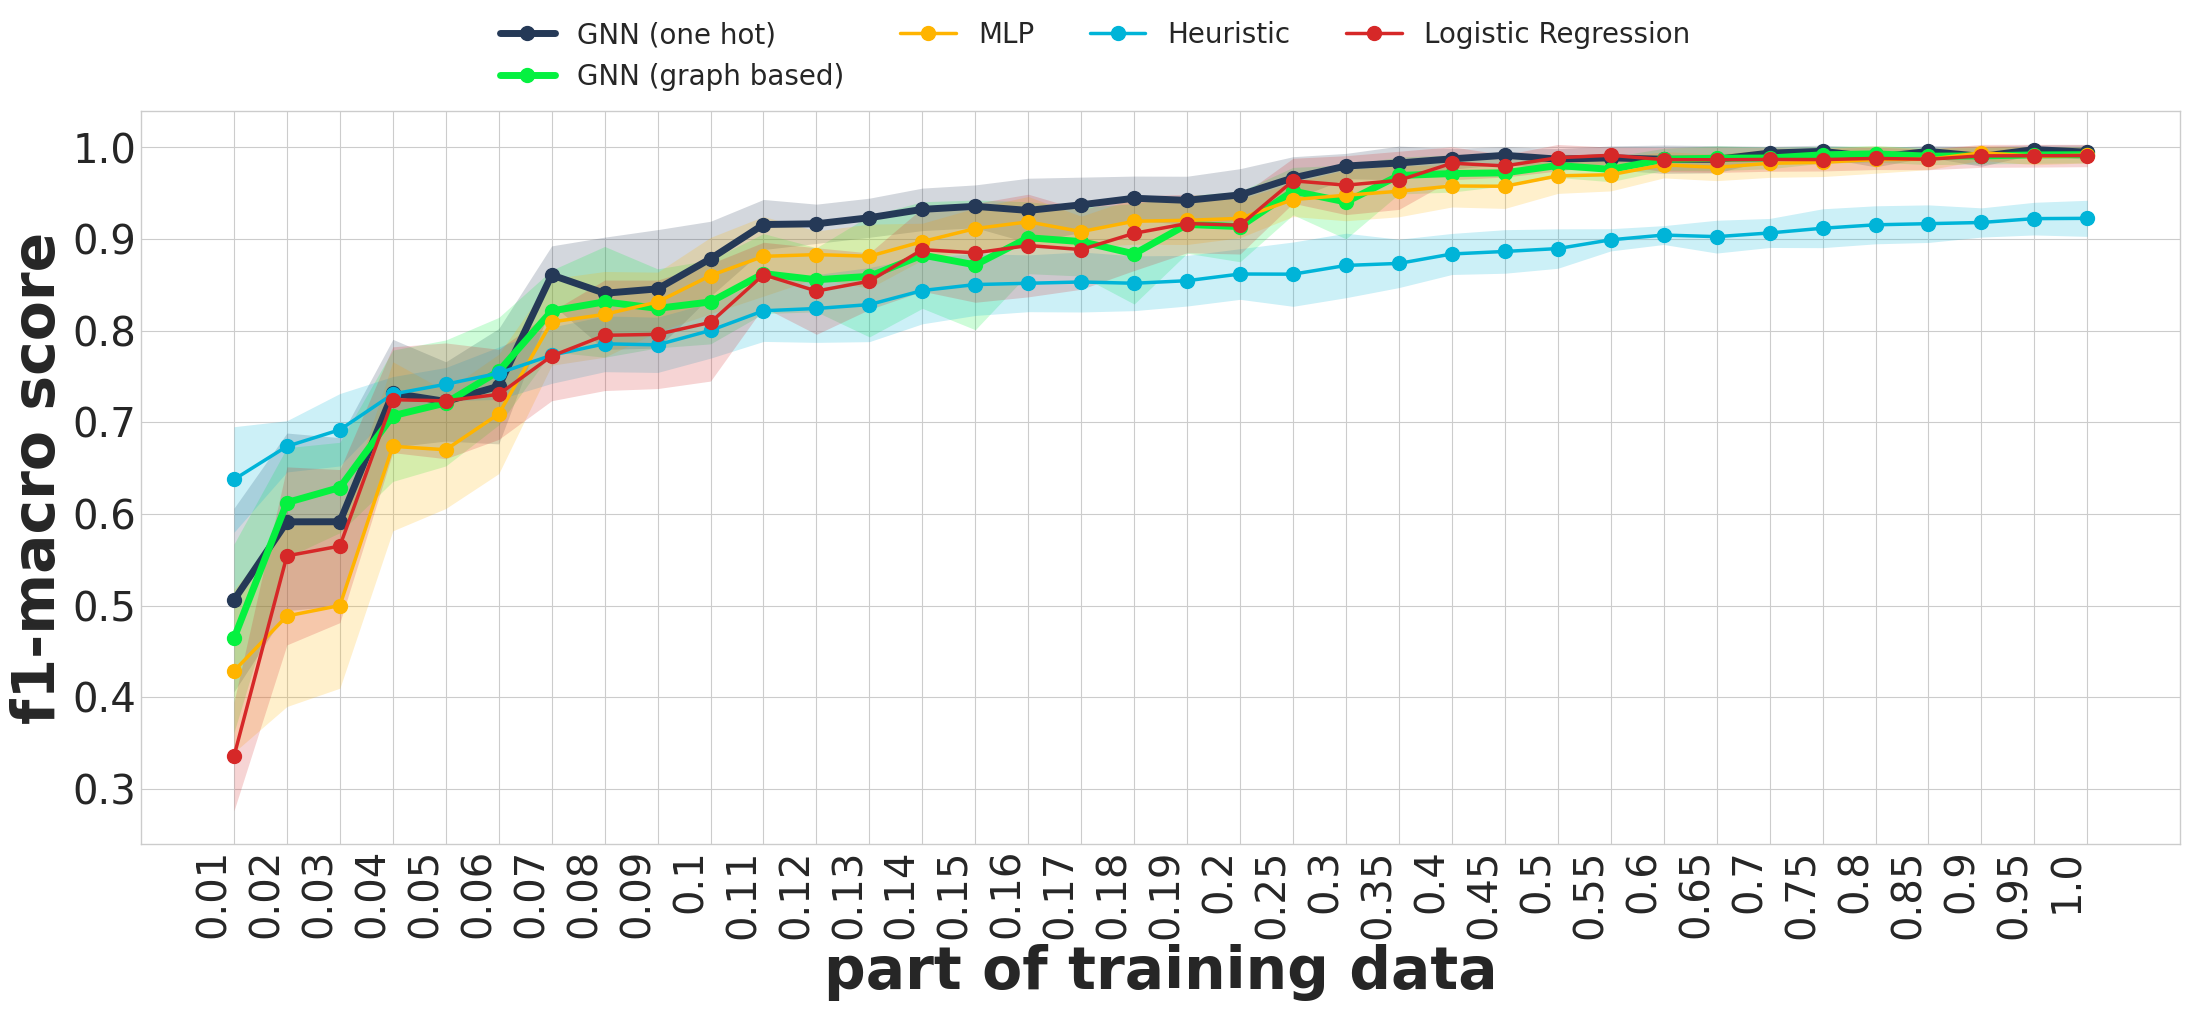

In [14]:
plot_test_1('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/dependensier_test_1', '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/dependensier_test_1/running_params.json')

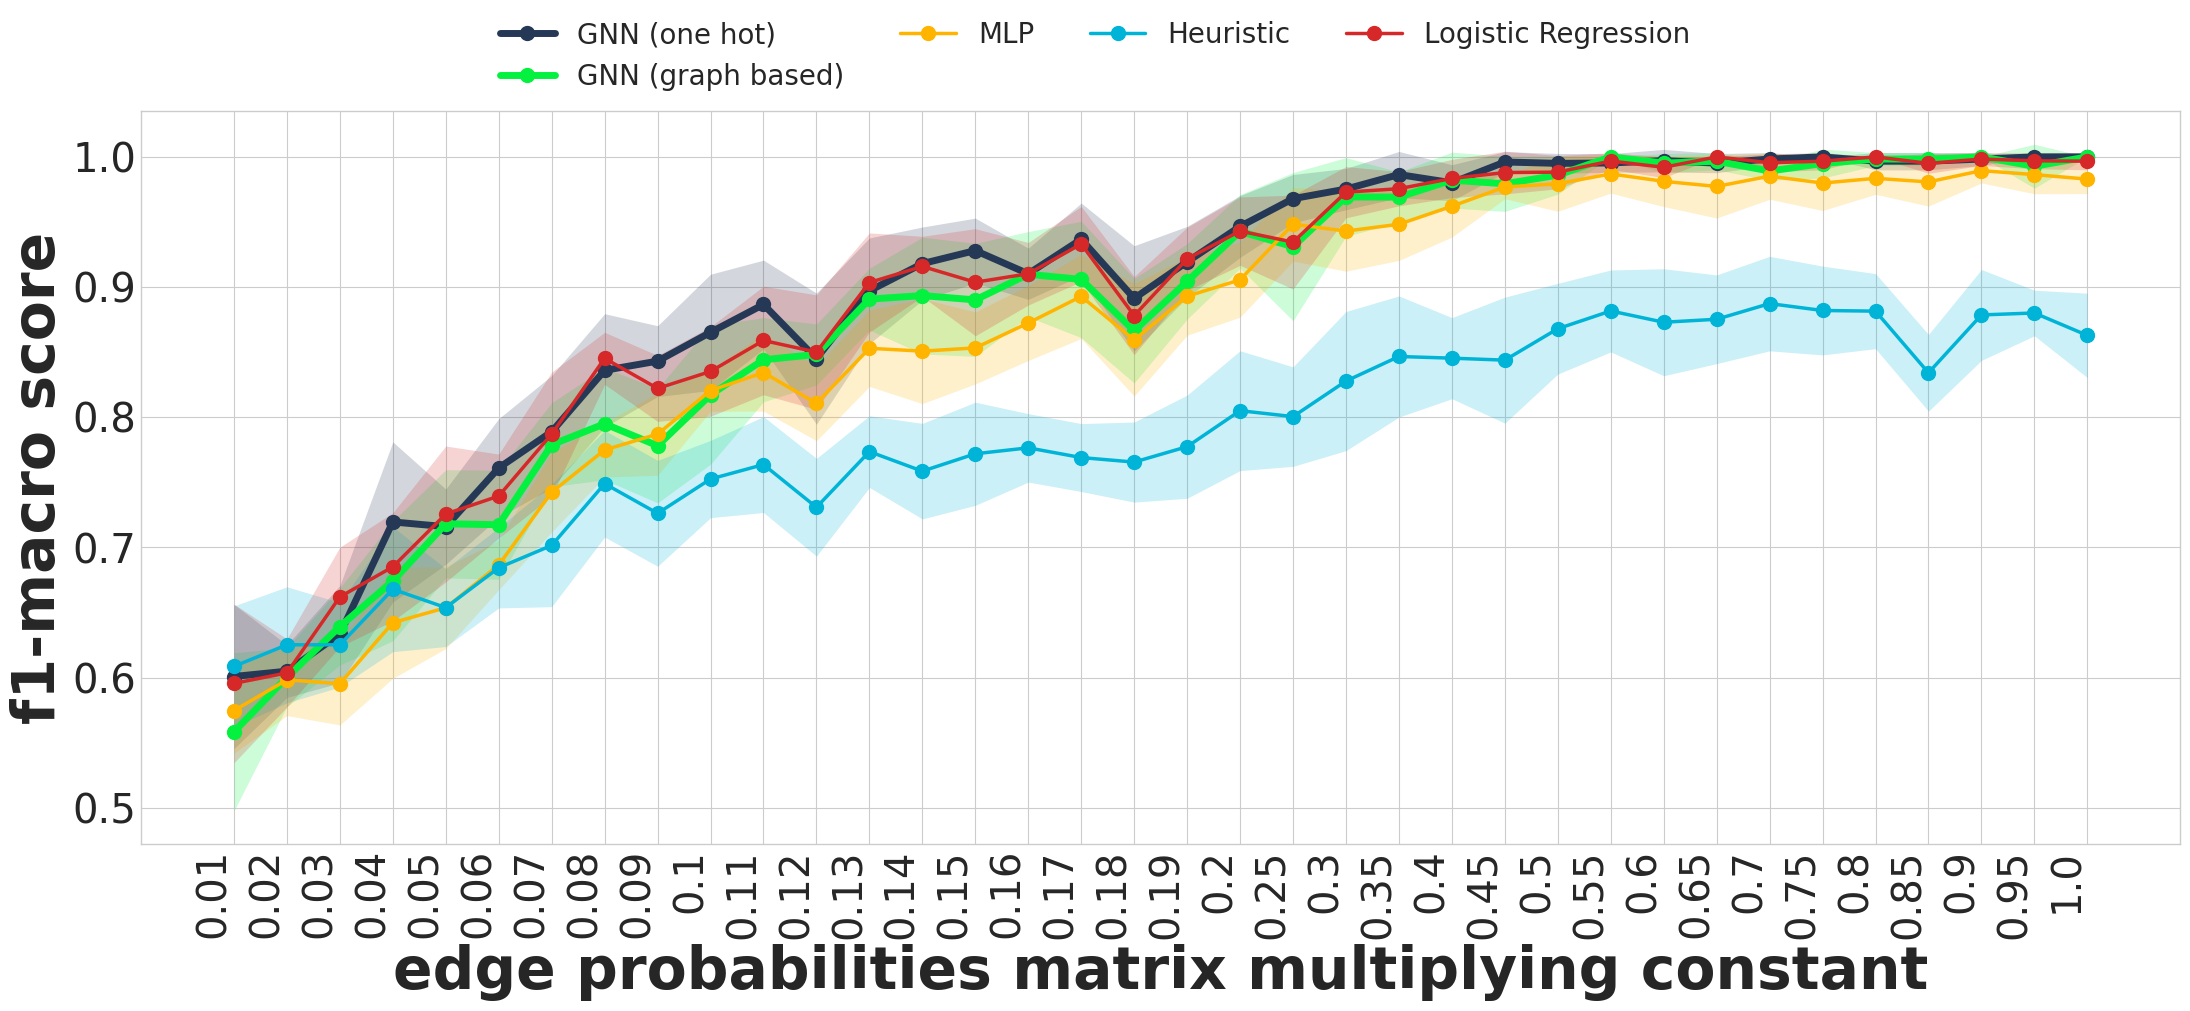

In [8]:
plot_test_2('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_simulation_decreaser')

In [2]:
def visualize_classifier_data_diagonal_changer(data_path):
    # Seaborn-like styling
    plt.style.use("seaborn-v0_8-whitegrid")

    # Fixed palette
    colors = {
        "GNN (one hot)"      : "#253957",  # deep blue
        "GNN (graph based)"  : "#05F140",  # vivid green
        "MLP"                : "#FFB400",  # orange
        "LR"                 : "#D62828",  # red
        "Heuristic"          : "#00B4D8",  # cyan
        "Community detection": "#6A4C93",  # unused here
    }

    # Collect means/stds
    predictions, predictions_std = {}, {}
    predictions['x'] = []

    all_dataset_dirs = [d for d in listdir(data_path) if isdir(join(data_path, d))]
    for dataset_dir in all_dataset_dirs:
        # x value from directory name (…_50 → 0.5)
        try:
            x_val = float(dataset_dir.split('_')[-1]) / 100.0
        except Exception:
            x_val = len(predictions['x'])
        predictions['x'].append(x_val)

        tmp = {}
        ds_path = join(data_path, dataset_dir)
        subdirs = [d for d in listdir(ds_path) if isdir(join(ds_path, d))]
        for sd in subdirs:
            with open(join(ds_path, sd, 'results.json'), 'r') as f:
                res = json.load(f)
            key = sd[:-8] if len(sd) >= 8 else sd  # strip split suffix if present
            tmp.setdefault(key, []).append(res['f1_macro'])

        # aggregate per model for this x
        for k, vals in tmp.items():
            m, s = np.mean(vals), np.std(vals)
            predictions.setdefault(k, []).append(m)
            predictions_std.setdefault(k, []).append(s)

    # Figure
    fig, ax = plt.subplots(figsize=(22, 10))

    # Sort/normalize x
    order = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[order]
    denom = max(len(x_labels) - 1, 1)
    x_plot = np.arange(len(x_labels)) / float(denom)

    # ----- model selection -----
    series_names = [k for k in predictions.keys() if k != 'x']

    def is_gl_lr(k):
        lk = k.lower().replace('-', '_')
        if 'gl_lr' in lk:
            return True
        toks = lk.split('_')
        return ('gl' in toks and 'lr' in toks) or (lk.startswith('gl') and 'lr' in toks)

    def pick_best(keys):
        return max(keys, key=lambda k: np.nanmean(predictions[k])) if keys else None

    # Split TAGConv into two GNN lines by feature
    tagconv_keys    = [k for k in series_names if 'tagconv' in k.lower()]
    tag_one_hot_key = pick_best([k for k in tagconv_keys if 'one_hot' in k.lower()])
    # accept both 'graph_based+' and 'graph_based' in file names; legend will say "graph based"
    tag_graph_key   = pick_best([k for k in tagconv_keys if ('graph_based+' in k.lower() or 'graph_based' in k.lower())])

    # Other models
    mlp_key = next((k for k in series_names if 'mlp' in k.lower()), None)
    lr_key  = next((k for k in series_names if is_gl_lr(k)), None)

    taken = {k for k in [tag_one_hot_key, tag_graph_key, mlp_key, lr_key] if k}
    heur_keys = [k for k in series_names if not k.lower().startswith('gl_') and k not in taken]
    best_heur_key = pick_best(heur_keys) if heur_keys else None

    # Legend labels & styles
    plot_specs = []  # (legend_label, model_key, color, linewidth)
    if tag_one_hot_key:
        plot_specs.append(('GNN (one hot)',      tag_one_hot_key, colors['GNN (one hot)'],     5))
    if tag_graph_key:
        plot_specs.append(('GNN (graph based)',  tag_graph_key,   colors['GNN (graph based)'], 5))
    if mlp_key:
        plot_specs.append(('MLP',                mlp_key,         colors['MLP'],               2.5))
    if best_heur_key:
        plot_specs.append(('Heuristic',          best_heur_key,   colors['Heuristic'],         2.5))
    if lr_key:
        plot_specs.append(('Logistic Regression',lr_key,          colors['LR'],                2.5))

    # Plot each selected series
    for label, key, col, lw in plot_specs:
        means = np.array(predictions[key])[order]
        stds  = np.array(predictions_std.get(key, [0]*len(predictions[key])))[order]
        ax.fill_between(x_plot, means - stds, means + stds, color=col, alpha=0.20, linewidth=0)
        ax.plot(x_plot, means, '-o', label=label, color=col, linewidth=lw, markersize=10)

    # Axes / legend
    ax.set_xlabel('diagonal probability multiplying constant', fontsize=42, fontweight='bold')
    ax.set_ylabel('f1-macro score',                             fontsize=42, fontweight='bold')
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=26)
    ax.tick_params(axis='y', labelsize=29)
    ax.tick_params(axis='x', labelsize=29)
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=min(len(labels), 4), fontsize=20, framealpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # Save & show (keep save logic)
    out_path = '/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures/diagonal_changer.pdf'
    plt.savefig(out_path, bbox_inches='tight')
    plt.show()


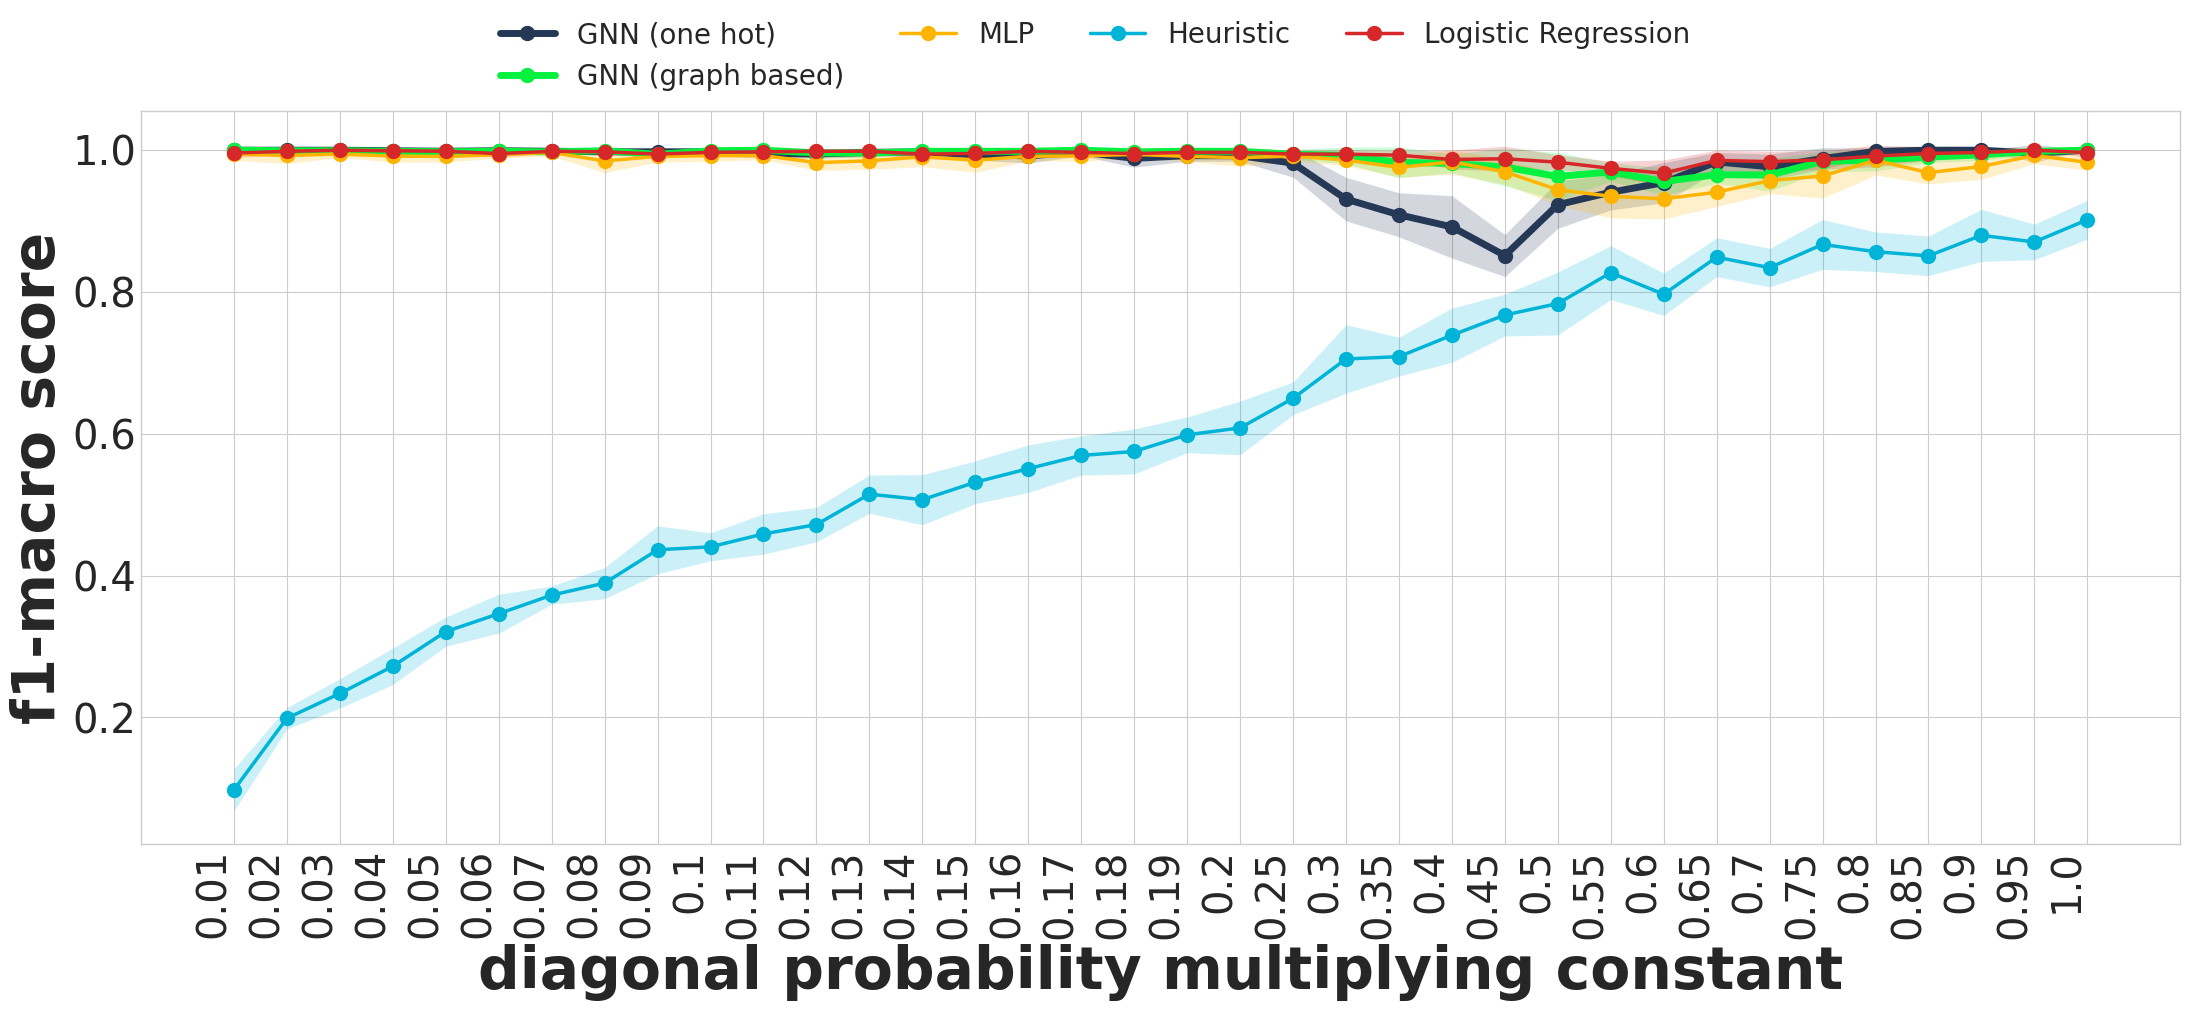

In [3]:
visualize_classifier_data_diagonal_changer('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_simulation_diagonal_changer')

Interpolation

In [73]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from os.path import isdir, join

def visualize_classifier_data_interpolation(data_path, fig_path, use_short_labels=True):
    """
    Creates a combined bar chart of classifier performance across datasets,
    hides x‐tick labels, and adds alternating background shading behind each group
    with adjustable width and distinct colors.

    Args:
        data_path (str): Path to folder with dataset subdirectories.
        fig_path (str): Directory to save the output figure.
        use_short_labels (bool): If True, use short labels (e.g. 'step_0#1'), else original names.
    """
    # Dataset directory to short abbreviation
    dataset_names = {
        'CR_class_balance_interpolation_step_0': 'step_0',
        'CR_class_balance_interpolation_step_1': 'step_1',
        'CR_class_balance_interpolation_step_2': 'step_2',
        'CR_class_balance_interpolation_step_3': 'step_3',
        'CR_class_balance_interpolation_step_4': 'step_4',
        'CR_class_balance_interpolation_step_5': 'step_5'
    }
    # Groups to include and their colors
    groups_order = ["GNN one hot", "GNN graph based", "Heuristic", "MLP"]
    group_to_color = {
        "GNN one hot":     "#253957",
        "GNN graph based": "#05F140",
        "Heuristic":       "#00B4D8",
        "MLP" :            "#FFB400"
    }
    group_to_index = {g: i for i, g in enumerate(groups_order)}

    combined = []
    # STEP 1: For each dataset, find the best model per group
    for dirname in listdir(data_path):
        if dirname not in dataset_names or not isdir(join(data_path, dirname)):
            continue
        ds_abbrev = dataset_names[dirname]
        per_model = {}

        for sub in listdir(join(data_path, dirname)):
            subpath = join(data_path, dirname, sub)
            if not isdir(subpath):
                continue
            try:
                with open(join(subpath, 'results.json')) as f:
                    res = json.load(f)
            except:
                continue
            name = res.get('model_name', '')
            # Determine feature type
            if 'graph_based' in sub:
                ft = 'graph_based'
            elif 'one_hot' in sub:
                ft = 'one_hot'
            else:
                ft = ''
            # Assign group
            if 'MLP' in name:
                grp = 'MLP'
            elif ft == 'graph_based':
                grp = 'GNN graph based'
            elif name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum',
                          'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                grp = 'Heuristic'
            else:
                grp = 'GNN one hot'
            if grp not in group_to_color:
                continue
            per_model.setdefault((grp, name), []).append(res.get('f1_macro', 0.0))

        if not per_model:
            continue
        df = pd.DataFrame([
            {'Group': g, 'ModelName': m,
             'Mean': np.mean(vals), 'StdDev': np.std(vals)}
            for (g, m), vals in per_model.items()
        ])
        best = []
        for grp in groups_order:
            subset = df[df['Group'] == grp]
            if not subset.empty:
                best.append(subset.loc[subset['Mean'].idxmax()])
        if best:
            df_best = pd.DataFrame(best)
            df_best['Dataset'] = ds_abbrev
            combined.append(df_best)

    if not combined:
        print("No classifier data found for the requested groups.")
        return

    # STEP 2: Combine all datasets and sort
    df_all = pd.concat(combined, ignore_index=True)
    order_list = list(dataset_names.values())
    df_all['Dataset'] = pd.Categorical(df_all['Dataset'], categories=order_list, ordered=True)
    df_all['GroupIdx'] = df_all['Group'].map(group_to_index)
    df_sorted = df_all.sort_values(['Dataset', 'GroupIdx']).reset_index(drop=True)

    # STEP 3: Compute X positions with gaps and record per-dataset spans
    counts = df_sorted.groupby('Dataset').size().reindex(order_list, fill_value=0)
    positions = []
    ds_positions = {}
    current_x = 0
    for ds in order_list:
        cnt = counts[ds]
        if cnt > 0:
            idxs = list(range(current_x, current_x + cnt))
            ds_positions[ds] = idxs
            positions.extend(idxs)
            current_x += cnt + 1
    positions = np.array(positions)

    # STEP 4: Create unique short labels
    unique_models = list(pd.unique(df_sorted['ModelName']))
    new_labels = [f"{ds}#{unique_models.index(name)}" for ds, name in zip(df_sorted['Dataset'], df_sorted['ModelName'])]
    original_labels = df_sorted['ModelName'].tolist()
    labels_to_use = new_labels if use_short_labels else original_labels

    # STEP 5: Plot
    fig, ax = plt.subplots(figsize=(max(10, 0.8 * len(df_sorted)), 6))

    # # Background shading with wider alternating bands
    # shading_margin = 1.0
    # light_shade = '#f2f2f2'
    # dark_shade  = '#cccccc'
    # for i, ds in enumerate(order_list):
    #     if ds in ds_positions:
    #         xs = ds_positions[ds]
    #         start = xs[0] - shading_margin
    #         end   = xs[-1] + shading_margin
    #         shade = light_shade if i % 2 == 0 else dark_shade
    #         ax.axvspan(start, end, ymin=0, ymax=1, facecolor=shade, zorder=0)

    # # ─────────────  ALTERNATING BACKGROUND (per‑dataset block)  ─────────────
    # bg_colors      = [(0.82, 0.93, 0.90),   # pastel aqua‑green
    #                 (0.32, 0.55, 0.66)]   # muted teal‑blue
    # default_margin = 0.35   # extra width on both sides of middle blocks
    # edge_extra     = 1.0     # how far first / last blocks extend past the frame

    # # remember limits so we can restore them after axvspan (axvspan auto‑expands)
    # orig_left, orig_right = ax.get_xlim()

    # for idx, ds in enumerate(order_list):
    #     if ds not in ds_positions:
    #         continue

    #     # block span in data coordinates
    #     xs = ds_positions[ds]
    #     x_min = xs[0] - default_margin
    #     x_max = xs[-1] + default_margin

    #     # let first / last dataset blocks “bleed” beyond the frame
    #     if idx == 0:                          # first block
    #         x_min = orig_left  - edge_extra
    #     if idx == len(order_list) - 1:        # last block
    #         x_max = orig_right + edge_extra

    #     ax.axvspan(
    #         x_min, x_max,
    #         color=bg_colors[idx % 2],
    #         alpha=0.5,
    #         zorder=0
    #     )

    # restore original limits so the axes frame stays put
    # ax.set_xlim(orig_left, orig_right)
    # ────────────────────────────────────────────────────────────────────────

    colors = [group_to_color[g] for g in df_sorted['Group']]
    bars = ax.bar(
        positions,
        df_sorted['Mean'],
        yerr=df_sorted['StdDev'],
        capsize=5,
        color=colors,
        edgecolor='black',
        zorder=1,
        error_kw={'ecolor': 'black'}
    )

    # ------------------ ADD ALTERNATING BACKGROUND HERE ------------------
    # pastel aqua‐green and muted teal‐blue
    bg_colors      = [(0.82, 0.93, 0.90), (0.32, 0.55, 0.66)]
    default_margin = 1.0   # normal extra width
    edge_extra     = 1.0    # how far first/last blocks extend past the frame

    # remember the original x‐limits (axvspan will otherwise expand them)
    orig_left, orig_right = ax.get_xlim()

    for idx, ds in enumerate(order_list):
        if ds not in ds_positions:
            continue

        xs = ds_positions[ds]
        x_min = xs[0] - default_margin
        x_max = xs[-1] + default_margin

        # first block: bleed off the left side
        if idx == 0:
            x_min = orig_left - edge_extra
        # last block: bleed off the right side
        if idx == len(order_list) - 1:
            x_max = orig_right + edge_extra

        ax.axvspan(
            x_min, x_max,
            color=bg_colors[idx % 2],
            alpha=0.5,
            zorder=0
        )

    # restore the original limits so the axes frame doesn’t shift
    ax.set_xlim(orig_left, orig_right)
    # ------------------ END BACKGROUND ADDITION ------------------

    # Annotate means and stddevs
    for bar, mean, sd in zip(bars, df_sorted['Mean'], df_sorted['StdDev']):
        x_c = bar.get_x() + bar.get_width() / 2
        ax.text(x_c, bar.get_height() / 2, f"{mean:.3f}", ha='center', va='center', rotation=90,
                color='white', fontsize=12, fontweight='bold')
        ax.text(x_c, bar.get_height() + 0.01, f"{sd:.3f}", ha='center', va='bottom', fontsize=10)

    # Hide x‐tick labels
    ax.set_xticks(positions)
    ax.set_xticklabels(labels_to_use, rotation=45, ha='right', fontsize=14, visible=False)
    ax.set_xlabel('models', fontsize=18)
    ax.set_ylabel('f1-macro score', fontsize=18)
    ax.tick_params(axis='y', labelsize=16)

    # Legend
    handles = [plt.Line2D([0], [0], marker='s', linestyle='None', markersize=10, color=group_to_color[g]) for g in groups_order]
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    fig.legend(handles, groups_order, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=4, fontsize=14)

    # Save and show
    plt.savefig(f"{fig_path}/combined_model_performance_interpolation.pdf", bbox_inches='tight')
    plt.show()

    # Print mapping
    mapping = {name: f"{ds}#{unique_models.index(name)}" for name, ds in zip(df_sorted['ModelName'], df_sorted['Dataset'])}
    print("Mapping of original model names to short labels:")
    print(mapping)


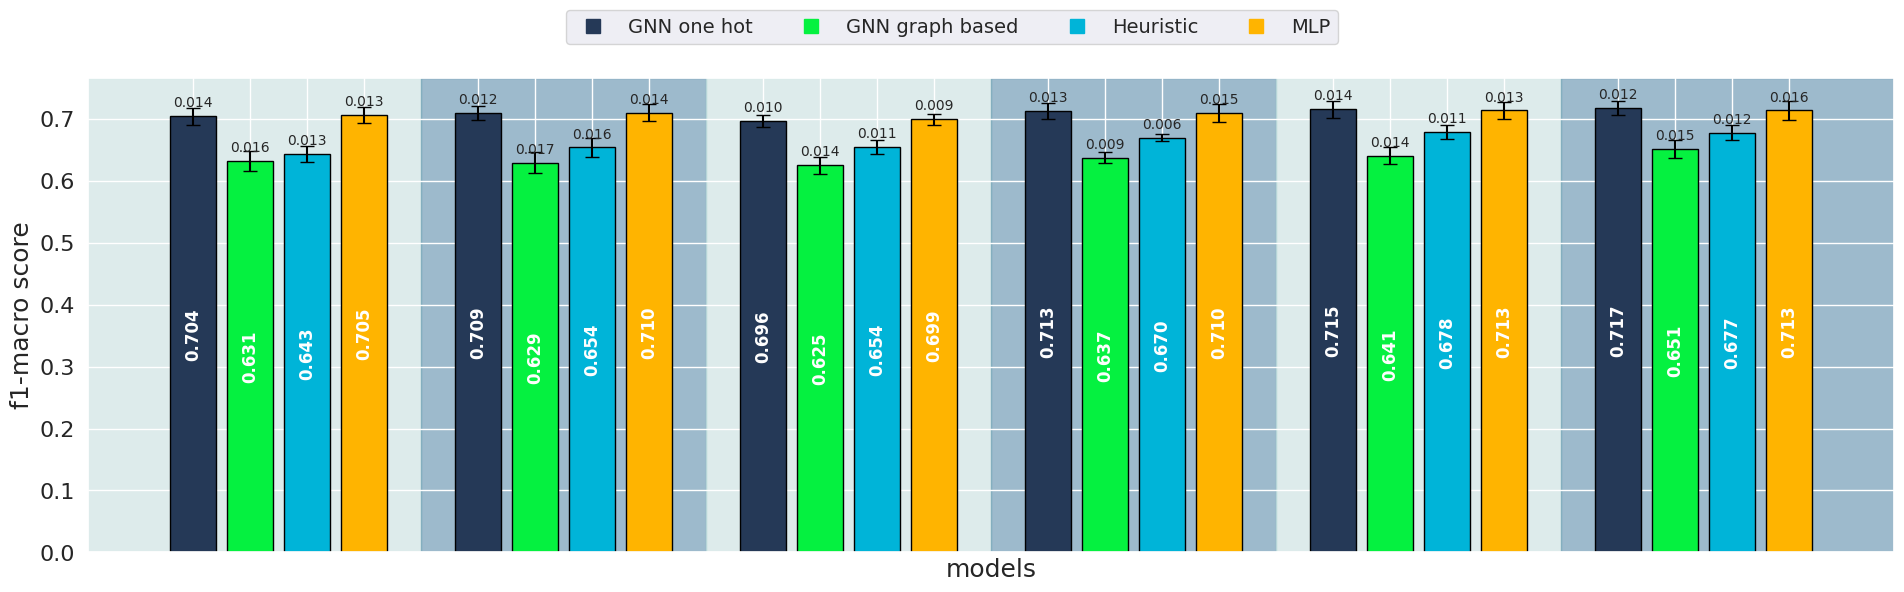

Mapping of original model names to short labels:
{'GL_TAGConv_3l_512h_w_k3_gnorm': 'step_5#0', 'MaxIbdSumPerClassSize': 'step_4#1', 'GL_MLP_3l_512h': 'step_5#2', 'MaxIbdSum': 'step_5#3'}


In [74]:
visualize_classifier_data_interpolation('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/genlink_simulated_real_data_class_balance_interpolation', 
                                        fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures',
                                        use_short_labels=True)

## Fig.1

### Different loss functions

In [7]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data_different_losses(
    data_path,
    fig_path=None,
    mask_percent=None,
    sort_bars=False,
    annotate=False,
    dataset_plot_only=None,
    class_plot_only=None,
    highlight_best=False,
    plot_best_per_class=True
):
    dataset_names = {
        'Western-Europe':'WE',
        'Volga':'VU',
        'NC_graph_rel_eng': 'NC',
        'Scandinavia': 'SC'
    }

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (
        np.array(all_dataset_dirs)[
            np.array(all_dataset_dirs) != 'dataset_stats'
        ]
    ).tolist()

    if dataset_plot_only is not None:
        all_dataset_dirs = (
            np.array(all_dataset_dirs)[
                np.array(all_dataset_dirs) == dataset_plot_only
            ]
        ).tolist()

    sns.set_theme()
    
    # -- NEW SUBPLOT LAYOUT FOR 5 SUBFIGURES --
    # We will create 3 rows, 2 columns using GridSpec:
    # rows 0 and 1 have 2 subplots each, row 2 spans both columns (1 wide subplot).
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:])
    axs = [ax1, ax2, ax3, ax4, ax5]
    ax_idx = 0
    # ----------------------------------------

    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        # If we already have 5 subplots, stop.
        if ax_idx >= 5:
            break

        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [
            f for f in listdir(all_models_per_dataset_path)
            if isdir(join(all_models_per_dataset_path, f))
        ]

        results = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''

                key = (curr_res['model_name'], ft)
                if key not in results:
                    results[key] = []

                if class_plot_only is None:
                    results[key].append(curr_res['f1_macro'])
                else:
                    results[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = {}
        for name_ft, metrics in results.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            all_fts.append(ft)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        # We'll only color-code for GNN one hot or GNN graph based:
        color_model_scheme = {
            'GNN one hot':'#253957',
            'GNN graph based':'#05F140'
        }
        cols, hue_names = [], []

        # Select specific rows from df
        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in [
            'GL_TAGConv_3l_512h_w_k3_gnorm',
            'GL_TAGConv_3l_512h_w_k3_gnorm_gelu',
            'GL_TAGConv_3l_512h_w_k3_gnorm_leaky_relu',
            'GL_TAGConv_3l_512h_w_k3_gnorm_relu'
        ]:
            best_model = df.loc[df['Classifier'] == u_n]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)

        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values(
                    'Mean',
                    ascending=False
                )

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # T-tests
            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(
                        one_best_model_per_class_df.iloc[0, 4],
                        one_best_model_per_class_df.iloc[i, 4],
                        equal_var=False
                    )
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    # If you had an MLP color, you'd add it, but your dict doesn't have it now
                    cols.append('#FFB400')
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                else:
                    # By default, treat everything else as GNN one-hot
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        # Pick the axis from our custom list
        ax = axs[ax_idx]
        
        # Draw the barplot
        bar_plot = sns.barplot(
            x=one_best_model_per_class_df.index,
            y=one_best_model_per_class_df.Mean,
            data=one_best_model_per_class_df,
            palette=color_model_scheme,
            hue=one_best_model_per_class_hue_names,
            ax=ax,
            legend=None
        )

        # Collect all bars
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Sort bars by x-position
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching for p-values > 0.05
        # for i, bar in enumerate(sorted_bars):
        #     if i < len(all_pvalues) and all_pvalues[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)

        # Label bars
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(
                bar_plot.containers[i],
                label_type='center',
                rotation=90,
                color='white',
                fontsize=20
            )

        # Draw error bars + optional std annotation
        for i, (mean, std) in enumerate(zip(
            one_best_model_per_class_df['Mean'],
            one_best_model_per_class_df['StdDev']
        )):
            ax.errorbar(
                i, mean, yerr=std, fmt='none', c='black', capsize=5
            )
            if annotate:
                ax.text(
                    i,
                    mean + std + 0.002,
                    f'{std:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=18
                )

        bar_plot.set_xticklabels(
            one_best_model_per_class_df.Classifier,
            rotation=90,
            ha='right',
            rotation_mode='anchor',
            fontsize=8
        )

        ax.tick_params(axis='x', which='both', labelbottom=False) ################################# turn off xticklabels ###########################

        # Use dataset_names if it matches dataset_dir; otherwise show dataset_dir
        if dataset_dir in dataset_names:
            ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        else:
            ax.set_title(f'{dataset_dir}', fontsize=30)

        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        # Set y-ticks
        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(
            np.min(one_best_model_per_class_df['Mean']) - 0.05,
            np.max(one_best_model_per_class_df['Mean']) + 0.05
        )

        ax_idx += 1

    # Remove duplicate handles and labels for the legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(
        unique_handles_labels.values(),
        unique_handles_labels.keys(),
        loc='upper center',
        ncol=2,
        fontsize=24,
        bbox_to_anchor=(0.5, 1.05)
    )

    # Add common X and Y labels
    fig.text(0.5, 0.02, 'model', ha='center', fontsize=29)
    fig.text(-0.02, 0.5, 'f1-macro score', va='center',
             rotation='vertical', fontsize=29)

    plt.tight_layout(rect=[0, 0.04, 1, 0.95])

    if fig_path is not None:
        plt.savefig(
            f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf',
            bbox_inches="tight"
        )

    plt.show()

In [8]:
visualize_classifier_data_different_losses('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_different_losses', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

/tmp/ipykernel_2374571/1527195949.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2374571/1527195949.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2374571/1527195949.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2374571/1527195949.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2374571/1527195949.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(


### W/wo wdge weights

In [111]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from itertools import combinations

from os import listdir
from os.path import isdir, join

# NEW import for flexible subplot arrangement
import matplotlib.gridspec as gridspec

def visualize_classifier_data_edge_weights(
    data_path,
    fig_path=None,
    mask_percent=None,
    sort_bars=False,
    annotate=False,
    dataset_plot_only=None,
    class_plot_only=None,
    highlight_best=False,
    plot_best_per_class=True
):
    dataset_names = {
        'Western-Europe':'WE',
        'Volga':'VU',
        'NC_graph_rel_eng': 'NC',
        'Scandinavia': 'SC'
    }

    all_dataset_dirs = [
        f for f in listdir(data_path)
        if isdir(join(data_path, f))
    ]
    # Remove 'dataset_stats' folder if present
    all_dataset_dirs = (
        np.array(all_dataset_dirs)[
            np.array(all_dataset_dirs) != 'dataset_stats'
        ]
    ).tolist()

    if dataset_plot_only is not None:
        all_dataset_dirs = (
            np.array(all_dataset_dirs)[
                np.array(all_dataset_dirs) == dataset_plot_only
            ]
        ).tolist()

    sns.set_theme()

    # --- NEW: Create up to 5 subplots (3 rows x 2 columns),
    #           with the last one spanning the entire 3rd row ---
    fig = plt.figure(figsize=(22, 16))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:])
    axs = [ax1, ax2, ax3, ax4, ax5]
    ax_idx = 0
    # ----------------------------------------------------------

    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        # If we already filled 5 subplots, stop
        if ax_idx >= 5:
            break

        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [
            f for f in listdir(all_models_per_dataset_path)
            if isdir(join(all_models_per_dataset_path, f))
        ]

        results = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''

                key = (curr_res['model_name'], ft)
                if key not in results:
                    results[key] = []

                if class_plot_only is None:
                    results[key].append(curr_res['f1_macro'])
                else:
                    results[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            all_fts.append(ft)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)
        
        # We'll just define a single color scheme (for 'NN only'):
        color_model_scheme = {'NN only': '#253957'}

        # Build a new aggregated dataframe for the two combos
        new_data = {
            'Classifier': [],
            'Mean': [],
            'StdDev': [],
            'all_means': [],
            'max_mean': []
        }

        arr_map = {'with_edge_weights': 'w', 'without_edge_weights': 'nw'}
        combinations_list = ['with_edge_weights', 'without_edge_weights']

        for combo in combinations_list:
            filtered_df = df[
                df['Classifier'].str.contains(arr_map[combo]) &
                df['Classifier'].str.contains('gnorm')
            ]
            new_data['Classifier'].append(combo)
            new_data['Mean'].append(filtered_df['Mean'].mean())
            new_data['max_mean'].append(filtered_df['Mean'].max())
            new_data['StdDev'].append(filtered_df['Mean'].std())
            new_data['all_means'].append(filtered_df['Mean'].to_numpy().tolist())

        one_best_model_per_class_df = pd.DataFrame(new_data)

        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values(
                    'Mean',
                    ascending=False
                )
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values(
                    'Mean',
                    ascending=False
                )
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # Compute p-values
            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(
                        one_best_model_per_class_df.iloc[0, 3],
                        one_best_model_per_class_df.iloc[i, 3],
                        equal_var=False
                    )
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

        # Pick the subplot axis from our custom list
        ax = axs[ax_idx]

        # Make the bar plot
        bar_plot = sns.barplot(
            x=one_best_model_per_class_df.index,
            y=one_best_model_per_class_df.Mean,
            data=one_best_model_per_class_df,
            color='#253957',
            ax=ax,
            legend=None
        )

        # Add a scatter for the max_mean values
        ax.scatter(
            [i for i in range(len(one_best_model_per_class_df))],
            one_best_model_per_class_df.max_mean,
            color='red',
            marker='o',
            s=50,
            zorder=3
        )

        # Collect all bars from the plot
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Sort the bars by center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, _ in sorted_bars_with_x]

        # Apply hatching if p-value > 0.05
        # for i, bar in enumerate(sorted_bars):
        #     if i < len(all_pvalues) and all_pvalues[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)

        # Label the bars internally
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(
                bar_plot.containers[i],
                fmt='%.4f',
                label_type='center',
                rotation=90,
                color='white',
                fontsize=20
            )

        # Add error bars + optional annotations
        for i, (mean, std) in enumerate(zip(
            one_best_model_per_class_df['Mean'],
            one_best_model_per_class_df['StdDev']
        )):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
            if annotate:
                ax.text(
                    i,
                    mean + std + 0.01,
                    f'{std:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=18
                )

        # Label x-axis
        bar_plot.set_xticklabels(
            one_best_model_per_class_df.Classifier,
            rotation=45,
            ha='right',
            rotation_mode='anchor',
            fontsize=18
        )

        # Title with dataset short name if available
        if dataset_dir in dataset_names:
            ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        else:
            ax.set_title(dataset_dir, fontsize=30)

        ax.set_xlabel('')
        ax.set_ylabel('')

        # Build legend data
        handles = [
            plt.Line2D([0], [0], color=color, lw=4)
            for color in color_model_scheme.values()
        ]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        # Set y-range
        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(
            np.min(one_best_model_per_class_df['Mean']) - 0.05,
            np.max(one_best_model_per_class_df['Mean']) + 0.05
        )

        ax_idx += 1

    # Remove duplicate legend entries
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(
        unique_handles_labels.values(),
        unique_handles_labels.keys(),
        loc='upper center',
        ncol=5,  # same as original code
        fontsize=24,
        bbox_to_anchor=(0.5, 1.0)
    )

    fig.text(0.5, 0.02, 'model type', ha='center', fontsize=29)
    fig.text(-0.02, 0.5, 'f1-macro score', va='center',
             rotation='vertical', fontsize=29)

    plt.tight_layout(rect=[0, 0.04, 1, 0.95])

    if fig_path is not None:
        plt.savefig(
            f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf',
            bbox_inches="tight"
        )

    plt.show()


/tmp/ipykernel_2154816/432067870.py:257: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/432067870.py:257: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/432067870.py:257: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/432067870.py:257: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/432067870.py:257: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(


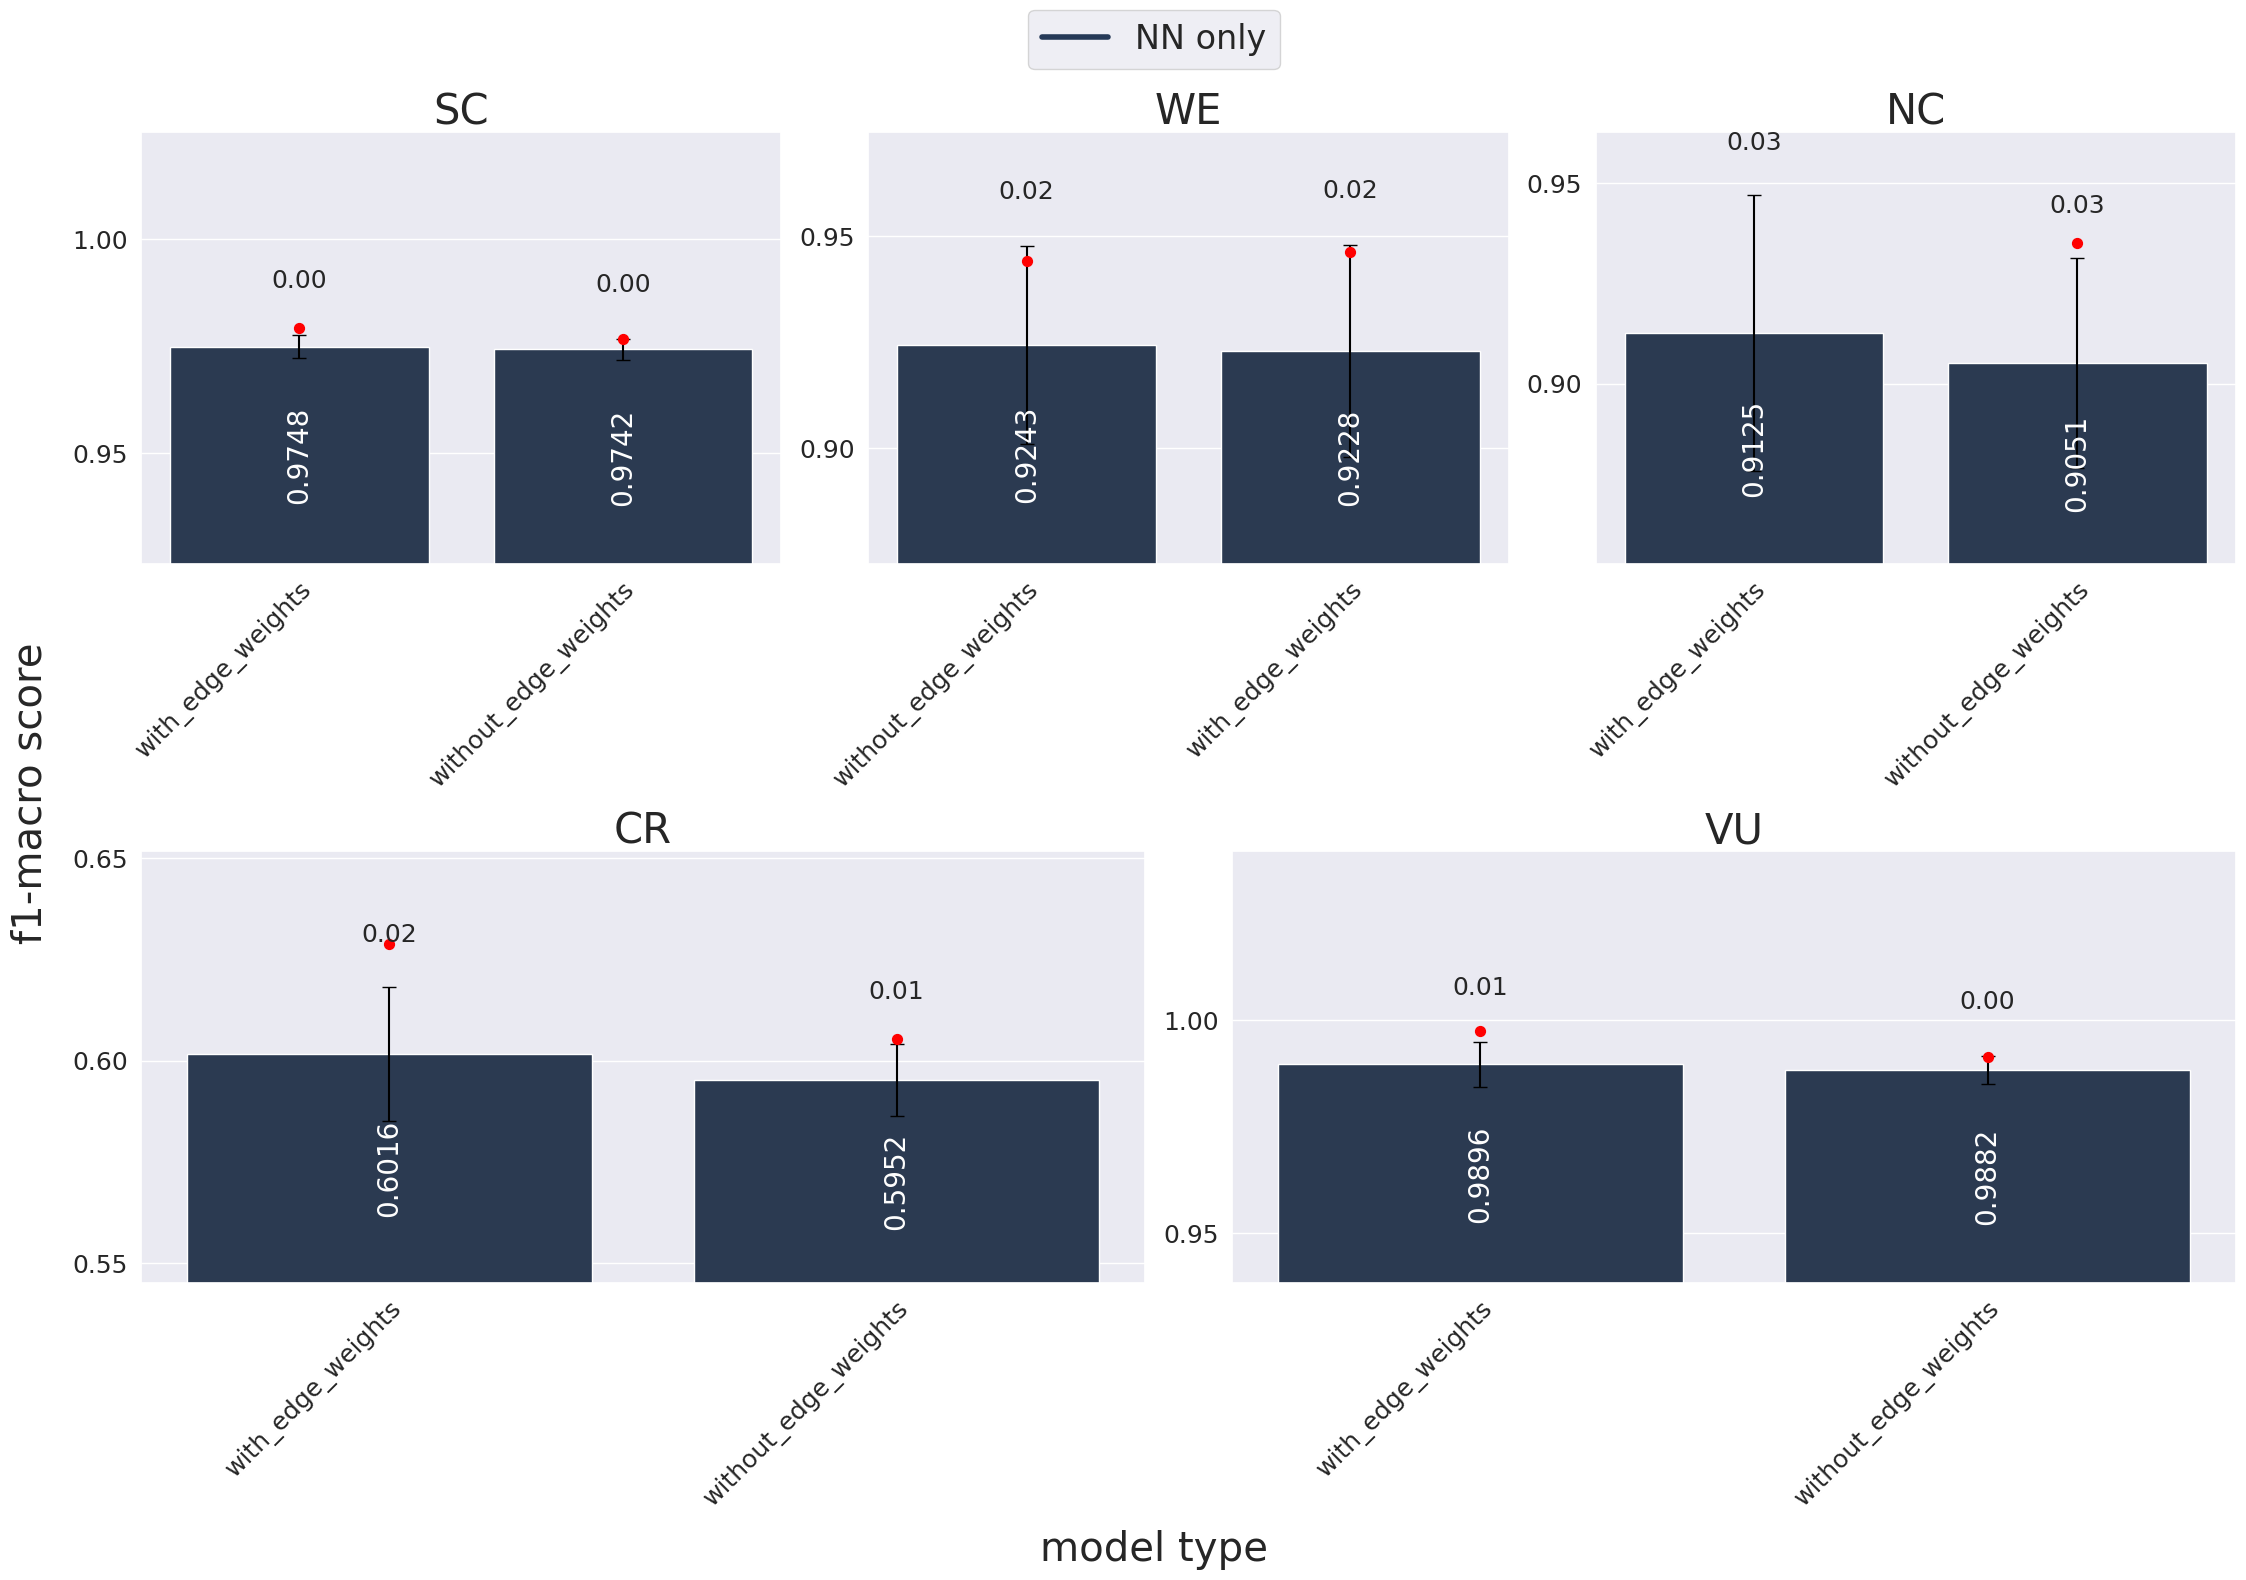

In [112]:
visualize_classifier_data_edge_weights('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_edge_weights', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### Nets configurations

In [89]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from itertools import combinations
from os import listdir
from os.path import isdir, join

# NEW import for flexible subplot arrangement
import matplotlib.gridspec as gridspec

def visualize_classifier_data_nets_configurations(
    data_path,
    fig_path=None,
    mask_percent=None,
    sort_bars=False,
    annotate=False,
    dataset_plot_only=None,
    class_plot_only=None,
    highlight_best=False,
    plot_best_per_class=True
):
    dataset_names = {
        'Western-Europe':'WE',
        'Volga':'VU',
        'NC_graph_rel_eng': 'NC',
        'Scandinavia': 'SC'
    }

    all_dataset_dirs = [
        f for f in listdir(data_path)
        if isdir(join(data_path, f))
    ]
    # Remove 'dataset_stats' if present
    all_dataset_dirs = (
        np.array(all_dataset_dirs)[
            np.array(all_dataset_dirs) != 'dataset_stats'
        ]
    ).tolist()

    if dataset_plot_only is not None:
        all_dataset_dirs = (
            np.array(all_dataset_dirs)[
                np.array(all_dataset_dirs) == dataset_plot_only
            ]
        ).tolist()

    sns.set_theme()

    # --- NEW SUBPLOT LAYOUT FOR UP TO 5 SUBFIGURES ---
    # 3 rows x 2 columns using GridSpec:
    #   Row 0: [0,0], [0,1]
    #   Row 1: [1,0], [1,1]
    #   Row 2: [2,:]  (spans both columns)
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:])
    axs = [ax1, ax2, ax3, ax4, ax5]
    ax_idx = 0
    # ------------------------------------------------

    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        # If we already filled 5 subplots, break
        if ax_idx >= 5:
            break

        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [
            f for f in listdir(all_models_per_dataset_path)
            if isdir(join(all_models_per_dataset_path, f))
        ]

        results = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''

                key = (curr_res['model_name'], ft)
                if key not in results:
                    results[key] = []

                if class_plot_only is None:
                    results[key].append(curr_res['f1_macro'])
                else:
                    results[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = {}
        for name_ft, metrics in results.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            all_fts.append(ft)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)
        df = df.reset_index(drop=True)

        color_model_scheme = {'NN only': '#253957'}

        # Build a new dataframe with specified rows/columns
        new_data = {
            'Classifier': [],
            'Mean': [],
            'StdDev': [],
            'all_means': [],
            'max_mean': []
        }

        arr = ['512h', '128h', '3l', '9l']
        combinations_list = [
            '_'.join(combo)
            for combo in combinations(arr, 2)
            if (
                (combo[0].endswith('h') and combo[1].endswith('l'))
                or (combo[0].endswith('l') and combo[1].endswith('h'))
            )
        ]

        for combo in combinations_list:
            parts = combo.split('_')
            # Filter df for each combination
            filtered_df = df[
                df['Classifier'].str.contains(parts[0]) &
                df['Classifier'].str.contains(parts[1]) &
                ~df['Classifier'].str.contains('relu') &
                ~df['Classifier'].str.contains('gelu') &
                ~df['Classifier'].str.contains('nw')
            ]
            new_data['Classifier'].append(combo)
            new_data['Mean'].append(filtered_df['Mean'].mean())
            new_data['max_mean'].append(filtered_df['Mean'].max())
            new_data['StdDev'].append(filtered_df['Mean'].std())
            new_data['all_means'].append(filtered_df['Mean'].to_numpy().tolist())

        one_best_model_per_class_df = pd.DataFrame(new_data)

        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values(
                    'Mean',
                    ascending=False
                )
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values(
                    'Mean',
                    ascending=False
                )
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # p-values for significance
            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(
                        one_best_model_per_class_df.iloc[0, 3],
                        one_best_model_per_class_df.iloc[i, 3],
                        equal_var=False
                    )
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

        # Pick axis from our custom list
        ax = axs[ax_idx]

        # Make barplot
        bar_plot = sns.barplot(
            x=one_best_model_per_class_df.index,
            y=one_best_model_per_class_df.Mean,
            data=one_best_model_per_class_df,
            color='#253957',
            ax=ax,
            legend=None
        )

        # Scatter for max_mean
        ax.scatter(
            [i for i in range(len(one_best_model_per_class_df))],
            one_best_model_per_class_df.max_mean,
            color='red',
            marker='o',
            s=50,
            zorder=3
        )

        # Collect bars
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Sort bars by center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, _ in sorted_bars_with_x]

        # Apply hatching for p-values > 0.05
        # for i, bar in enumerate(sorted_bars):
        #     if i < len(all_pvalues) and all_pvalues[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)

        # Label inside the bars
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(
                bar_plot.containers[i],
                fmt='%.4f',
                label_type='center',
                rotation=90,
                color='white',
                fontsize=20
            )

        # Error bars + optional annotation
        for i, (mean, std) in enumerate(zip(
            one_best_model_per_class_df['Mean'],
            one_best_model_per_class_df['StdDev']
        )):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
            if annotate:
                ax.text(
                    i,
                    mean + std + 0.01,
                    f'{std:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=18
                )

        bar_plot.set_xticklabels(
            one_best_model_per_class_df.Classifier,
            rotation=45,
            ha='right',
            rotation_mode='anchor',
            fontsize=20
        )

        # Use short name if available
        if dataset_dir in dataset_names:
            ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        else:
            ax.set_title(f'{dataset_dir}', fontsize=30)

        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles/labels
        handles = [
            plt.Line2D([0], [0], color=color, lw=4)
            for color in color_model_scheme.values()
        ]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax.set_yticks([i * 0.1 for i in range(11)])
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(
            np.min(one_best_model_per_class_df['Mean']) - 0.3,
            np.max(one_best_model_per_class_df['Mean']) + 0.2
        )

        ax_idx += 1

    # Remove duplicate handles/labels
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(
        unique_handles_labels.values(),
        unique_handles_labels.keys(),
        loc='upper center',
        ncol=5,
        fontsize=24,
        bbox_to_anchor=(0.5, 1.05)
    )

    fig.text(0.5, 0.02, 'model type', ha='center', fontsize=29)
    fig.text(-0.02, 0.5, 'f1-macro score',
             va='center', rotation='vertical', fontsize=29)

    plt.tight_layout(rect=[0, 0.04, 1, 0.95])

    if fig_path is not None:
        plt.savefig(
            f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf',
            bbox_inches="tight"
        )

    plt.show()


In [90]:
visualize_classifier_data_nets_configurations('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_net_configs', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

/tmp/ipykernel_2154816/617932841.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/617932841.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/617932841.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/617932841.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(
/tmp/ipykernel_2154816/617932841.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(


### Masks, base scores

In [45]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import ttest_ind
from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data_all_masks(
    data_paths,
    fig_path=None,
    mask_percent=None,
    sort_bars=False,
    annotate=False,
    dataset_not_to_plot=None,
    class_plot_only=None,
    highlight_best=False,
    plot_best_per_class=True
):
    dataset_names = {
        'Volga':'VU',
        'NC_graph_rel_eng': 'NC',
        'Western-Europe':'WE',
        'Scandinavia': 'SC'
    }

    color_model_scheme = {
        'GNN one hot':'#253957',
        'GNN graph based':'#05F140',
        'MLP':'#FFB400',
        'Heuristic':'#00B4D8',
        'Community detection': '#EF233C'
    }

    sns.set_theme()

    # ----- NEW FIGURE/AXES CREATION WITH GRIDSPEC -----
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:])
    ax3 = fig.add_subplot(gs[1, :3])
    ax4 = fig.add_subplot(gs[1, 3:])
    axs = [ax1, ax2, ax3, ax4]
    # ---------------------------------------------------

    ax_idx = 0
    all_handles, all_labels = [], []

    # We'll iterate over at most 5 dataset directories, ensuring we only fill 5 subplots
    for dataset_dir_idx, dataset_dir in enumerate(dataset_names.keys()):
        if ax_idx >= 5:
            break

        combined_data = []
        hue_names_combined = []

        ax = axs[ax_idx]

        for data_path_idx, data_path in enumerate(data_paths):
            all_dataset_dirs = [
                f for f in listdir(data_path)
                if isdir(join(data_path, f))
            ]
            all_dataset_dirs = (
                np.array(all_dataset_dirs)[
                    np.array(all_dataset_dirs) != 'dataset_stats'
                ]
            ).tolist()

            if dataset_not_to_plot is not None:
                all_dataset_dirs = (
                    np.array(all_dataset_dirs)[
                        np.array(all_dataset_dirs) != dataset_not_to_plot
                    ]
                ).tolist()

            if dataset_dir not in all_dataset_dirs:
                continue

            all_models_per_dataset_path = join(data_path, dataset_dir)
            all_dirs = [
                f for f in listdir(all_models_per_dataset_path)
                if isdir(join(all_models_per_dataset_path, f))
            ]

            results = dict()
            for dir_path in all_dirs:
                with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    key = (curr_res['model_name'], ft)

                    if key not in results:
                        results[key] = []

                    if class_plot_only is None:
                        results[key].append(curr_res['f1_macro'])
                    else:
                        results[key].append(curr_res['class_scores'][class_plot_only])

            classifiers = dict()
            for name_ft, metrics in results.items():
                name, ft = name_ft
                mean_val = np.mean(metrics)
                std_val = np.std(metrics)
                classifiers[name_ft] = [mean_val, std_val, metrics]

            classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []

            for name_ft, metrics in classifiers.items():
                name, ft = name_ft
                classifier_names.append(name)
                all_fts.append(ft)
                means.append(metrics[0])
                std_devs.append(metrics[1])
                all_metrics.append(metrics[2])

            df = pd.DataFrame({
                'Classifier': classifier_names,
                'Mean': np.round(means, 4),
                'StdDev': std_devs,
                'feature_type': all_fts,
                'all_metrics': all_metrics,
                'Data_Path_Index': data_path_idx
            })

            if sort_bars:
                df = df.sort_values('Mean', ascending=False)

            df = df.reset_index(drop=True)

            # Assign color and hue names
            cols, hue_names = [], []
            for index, row in df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    hue_names.append('GNN graph based')
                elif model_name in [
                    'MaxEdgeCount',
                    'MaxEdgeCountPerClassSize',
                    'MaxIbdSum',
                    'MaxIbdSumPerClassSize',
                    'LongestIbd',
                    'MaxSegmentCount'
                ]:
                    cols.append(color_model_scheme['Heuristic'])
                    hue_names.append('Heuristic')
                elif model_name in [
                    'AgglomerativeClustering',
                    'GirvanNewmann',
                    'LabelPropagation',
                    'MultiRankWalk',
                    'RelationalNeighborClassifier',
                    'RidgeRegression',
                    'SpectralClustering'
                ]:
                    cols.append(color_model_scheme['Community detection'])
                    hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    hue_names.append('GNN one hot')

            # Select one best model per class for each dataframe before combining
            one_best_model_per_class_df = []
            one_best_model_hue_names = []
            unique_hue_names = np.unique(hue_names)
            for u_n in unique_hue_names:
                current_df = df.loc[np.array(hue_names) == u_n]
                best_model = current_df.loc[[current_df['Mean'].idxmax()]]
                one_best_model_per_class_df.append(best_model)
                one_best_model_hue_names.append(u_n)

            one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            df = one_best_model_per_class_df

            if sort_bars:
                df = df.sort_values(by=['Mean'], ascending=[False])

            tmp_pvalues = []
            for i in range(df.shape[0]):
                if i == 0:
                    tmp_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                    tmp_pvalues.append(p_value)

            df['all_pvalues'] = [p * 4 for p in tmp_pvalues]  # corrected for multiple comparisons

            combined_data.append(df)
            hue_names_combined += one_best_model_hue_names

        if len(combined_data) == 0:
            continue

        combined_data_df = pd.concat(combined_data)
        combined_data_df = combined_data_df.reset_index(drop=True)

        if plot_best_per_class:
            if sort_bars:
                combined_data_df = combined_data_df.sort_values(
                    by=['Data_Path_Index', 'Mean'],
                    ascending=[True, False]
                )

            combined_data_df = combined_data_df.reset_index(drop=True)
            cols = []
            for index, row in combined_data_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                elif model_name in [
                    'MaxEdgeCount',
                    'MaxEdgeCountPerClassSize',
                    'MaxIbdSum',
                    'MaxIbdSumPerClassSize',
                    'LongestIbd',
                    'MaxSegmentCount'
                ]:
                    cols.append(color_model_scheme['Heuristic'])
                elif model_name in [
                    'AgglomerativeClustering',
                    'GirvanNewmann',
                    'LabelPropagation',
                    'MultiRankWalk',
                    'RelationalNeighborClassifier',
                    'RidgeRegression',
                    'SpectralClustering'
                ]:
                    cols.append(color_model_scheme['Community detection'])
                else:
                    cols.append(color_model_scheme['GNN one hot'])

        # Plot the bars
        x_positions = combined_data_df.index + np.array([i // 4 for i in range(len(combined_data_df.index))]) / 2
        bars = ax.bar(
            x_positions,
            combined_data_df['Mean'],
            yerr=combined_data_df['StdDev'],
            color=cols,
            capsize=5,
            error_kw={'elinewidth': 1, 'ecolor': 'black'}
        )

        # ------------------ ADD ALTERNATING BACKGROUND HERE ------------------
        bars_xy  = [(bar.get_x(), bar.get_width()) for bar in bars]
        n_groups = int(np.ceil(len(bars_xy) / 4))
        bg_colors = [(0.82, 0.93, 0.90),   # pastel aqua‑green (light blue‑green)
             (0.32, 0.55, 0.66)]   # muted teal‑blue (darker)
        
        default_margin = 0.35       # keep for middle blocks
        edge_extra     = 1.0        # how far past the frame the first/last spans go

        # remember current limits so we can restore them later
        orig_left, orig_right = ax.get_xlim()

        for g in range(n_groups):
            start_idx = g * 4
            end_idx   = min((g + 1) * 4 - 1, len(bars_xy) - 1)

            x_min = bars_xy[start_idx][0]               - default_margin
            x_max = bars_xy[end_idx][0] + bars_xy[end_idx][1] + default_margin

            # push the first / last blocks beyond the plot edges
            if g == 0:
                x_min = orig_left  - edge_extra
            if g == n_groups - 1:
                x_max = orig_right + edge_extra

            ax.axvspan(x_min, x_max,
                    color=bg_colors[g % 2],
                    alpha=0.5, zorder=0)

        # restore the original axes limits so the picture frame doesn’t expand
        ax.set_xlim(orig_left, orig_right)
        # ------------------ END BACKGROUND ADDITION ------------------

        # Sort bars by their x-position so p-values align
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, _ in sorted_bars_with_x]

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(combined_data_df['Mean']) - 0.1, np.max(combined_data_df['Mean']) + 0.1)

        for bar in bars:
            height = bar.get_height()
            label_position = (height - np.min(combined_data_df['Mean'] + 0.1)) / 2
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                np.min(combined_data_df['Mean']) + label_position,
                f'{height:.4f}',
                ha='center',
                va='center',
                rotation=90,
                color='white',
                fontsize=10
            )

        if annotate:
            for i, (mean, std) in enumerate(zip(combined_data_df['Mean'], combined_data_df['StdDev'])):
                ax.text(
                    x_positions[i],
                    mean + std + 0.01,
                    f'{std:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=10
                )

        ax.set_xticks(x_positions)
        ax.set_xticklabels(
            [
                name + f' ({i // 4 * 25}%)'
                for i, name in enumerate(combined_data_df['Classifier'])
            ],
            rotation=90,
            ha='right',
            rotation_mode='anchor',
            fontsize=8
        )

        # Highlight GNN-based models in red/bold if they appear first in each group of 4
        flag = True
        for i in range(len(ax.get_xticklabels())):
            text_label = ax.get_xticklabels()[i].get_text().split(' ')[0]
            if i % 4 == 0:
                flag = True
            if text_label in [
                'MaxEdgeCount', 'MaxEdgeCountPerClassSize',
                'MaxIbdSum', 'MaxIbdSumPerClassSize',
                'LongestIbd', 'MaxSegmentCount'
            ]:
                flag = False
            elif flag:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        ax.tick_params(axis='x', which='both', labelbottom=False)

        ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend info
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax_idx += 1

    # Remove duplicates from legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    if 'Community detection' in unique_handles_labels:
        del unique_handles_labels['Community detection']

    fig.legend(
        unique_handles_labels.values(),
        unique_handles_labels.keys(),
        loc='upper center',
        ncol=4,
        fontsize=24,
        bbox_to_anchor=(0.5, 1.05)
    )

    fig.text(0.5, -0.02, 'model', ha='center', fontsize=29)
    fig.text(-0.01, 0.5, 'f1-macro score', va='center', rotation='vertical', fontsize=29)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_all_masks.pdf', bbox_inches="tight")

    plt.show()


In [46]:
visualize_classifier_data_all_masks(['/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_0',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_25',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_50',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_75',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_100'], sort_bars=True, annotate=True, mask_percent='all', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True,
                                     dataset_not_to_plot='CR')

/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shm

In [39]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import ttest_ind
from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data_all_masks_mod(
    data_paths,
    fig_path=None,
    mask_percent=None,
    sort_bars=False,
    annotate=False,
    dataset_plot_only=None,
    class_plot_only=None,
    highlight_best=False,
    plot_best_per_class=True
):
    dataset_names = {
        'Volga':'VU',
        'NC_graph_rel_eng': 'NC',
        'Western-Europe':'WE',
        'Scandinavia': 'SC',
        'CR':'CR'
    }

    color_model_scheme = {
        'GNN one hot':'#253957',
        'GNN graph based':'#05F140',
        'MLP':'#FFB400',
        'Heuristic':'#00B4D8',
        'Community detection': '#EF233C'
    }

    sns.set_theme()

    # ----- NEW FIGURE/AXES CREATION WITH GRIDSPEC -----
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[:, :])
    axs = [ax1]
    # ---------------------------------------------------

    ax_idx = 0
    all_handles, all_labels = [], []

    # We'll iterate over at most 5 dataset directories, ensuring we only fill 5 subplots
    for dataset_dir_idx, dataset_dir in enumerate(dataset_names.keys()):
        if ax_idx >= 5:
            break

        combined_data = []
        hue_names_combined = []

        ax = axs[ax_idx]

        for data_path_idx, data_path in enumerate(data_paths):
            all_dataset_dirs = [
                f for f in listdir(data_path)
                if isdir(join(data_path, f))
            ]
            all_dataset_dirs = (
                np.array(all_dataset_dirs)[
                    np.array(all_dataset_dirs) != 'dataset_stats'
                ]
            ).tolist()

            if dataset_plot_only is not None:
                all_dataset_dirs = (
                    np.array(all_dataset_dirs)[
                        np.array(all_dataset_dirs) == dataset_plot_only
                    ]
                ).tolist()

            if dataset_dir not in all_dataset_dirs:
                continue

            all_models_per_dataset_path = join(data_path, dataset_dir)
            all_dirs = [
                f for f in listdir(all_models_per_dataset_path)
                if isdir(join(all_models_per_dataset_path, f))
            ]

            results = dict()
            for dir_path in all_dirs:
                with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    key = (curr_res['model_name'], ft)

                    if key not in results:
                        results[key] = []

                    if class_plot_only is None:
                        results[key].append(curr_res['f1_macro'])
                    else:
                        results[key].append(curr_res['class_scores'][class_plot_only])

            classifiers = dict()
            for name_ft, metrics in results.items():
                name, ft = name_ft
                mean_val = np.mean(metrics)
                std_val = np.std(metrics)
                classifiers[name_ft] = [mean_val, std_val, metrics]

            classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []

            for name_ft, metrics in classifiers.items():
                name, ft = name_ft
                classifier_names.append(name)
                all_fts.append(ft)
                means.append(metrics[0])
                std_devs.append(metrics[1])
                all_metrics.append(metrics[2])

            df = pd.DataFrame({
                'Classifier': classifier_names,
                'Mean': np.round(means, 4),
                'StdDev': std_devs,
                'feature_type': all_fts,
                'all_metrics': all_metrics,
                'Data_Path_Index': data_path_idx
            })

            if sort_bars:
                df = df.sort_values('Mean', ascending=False)

            df = df.reset_index(drop=True)

            # Assign color and hue names
            cols, hue_names = [], []
            for index, row in df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    hue_names.append('GNN graph based')
                elif model_name in [
                    'MaxEdgeCount',
                    'MaxEdgeCountPerClassSize',
                    'MaxIbdSum',
                    'MaxIbdSumPerClassSize',
                    'LongestIbd',
                    'MaxSegmentCount'
                ]:
                    cols.append(color_model_scheme['Heuristic'])
                    hue_names.append('Heuristic')
                elif model_name in [
                    'AgglomerativeClustering',
                    'GirvanNewmann',
                    'LabelPropagation',
                    'MultiRankWalk',
                    'RelationalNeighborClassifier',
                    'RidgeRegression',
                    'SpectralClustering'
                ]:
                    cols.append(color_model_scheme['Community detection'])
                    hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    hue_names.append('GNN one hot')

            # Select one best model per class for each dataframe before combining
            one_best_model_per_class_df = []
            one_best_model_hue_names = []
            unique_hue_names = np.unique(hue_names)
            for u_n in unique_hue_names:
                current_df = df.loc[np.array(hue_names) == u_n]
                best_model = current_df.loc[[current_df['Mean'].idxmax()]]
                one_best_model_per_class_df.append(best_model)
                one_best_model_hue_names.append(u_n)

            one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            df = one_best_model_per_class_df

            if sort_bars:
                df = df.sort_values(by=['Mean'], ascending=[False])

            tmp_pvalues = []
            for i in range(df.shape[0]):
                if i == 0:
                    tmp_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                    tmp_pvalues.append(p_value)

            df['all_pvalues'] = [p * 4 for p in tmp_pvalues]  # corrected for multiple comparisons

            combined_data.append(df)
            hue_names_combined += one_best_model_hue_names

        if len(combined_data) == 0:
            continue

        combined_data_df = pd.concat(combined_data)
        combined_data_df = combined_data_df.reset_index(drop=True)

        if plot_best_per_class:
            if sort_bars:
                combined_data_df = combined_data_df.sort_values(
                    by=['Data_Path_Index', 'Mean'],
                    ascending=[True, False]
                )

            combined_data_df = combined_data_df.reset_index(drop=True)
            cols = []
            for index, row in combined_data_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                elif model_name in [
                    'MaxEdgeCount',
                    'MaxEdgeCountPerClassSize',
                    'MaxIbdSum',
                    'MaxIbdSumPerClassSize',
                    'LongestIbd',
                    'MaxSegmentCount'
                ]:
                    cols.append(color_model_scheme['Heuristic'])
                elif model_name in [
                    'AgglomerativeClustering',
                    'GirvanNewmann',
                    'LabelPropagation',
                    'MultiRankWalk',
                    'RelationalNeighborClassifier',
                    'RidgeRegression',
                    'SpectralClustering'
                ]:
                    cols.append(color_model_scheme['Community detection'])
                else:
                    cols.append(color_model_scheme['GNN one hot'])

        # Plot the bars
        x_positions = combined_data_df.index + np.array([i // 4 for i in range(len(combined_data_df.index))]) / 2
        bars = ax.bar(
            x_positions,
            combined_data_df['Mean'],
            yerr=combined_data_df['StdDev'],
            color=cols,
            capsize=5,
            error_kw={'elinewidth': 1, 'ecolor': 'black'}
        )

        # ------------------ ADD ALTERNATING BACKGROUND HERE ------------------
        bars_xy  = [(bar.get_x(), bar.get_width()) for bar in bars]
        n_groups = int(np.ceil(len(bars_xy) / 4))
        bg_colors = [(0.82, 0.93, 0.90),   # pastel aqua‑green (light blue‑green)
             (0.32, 0.55, 0.66)]   # muted teal‑blue (darker)
        
        default_margin = 0.35       # keep for middle blocks
        edge_extra     = 1.0        # how far past the frame the first/last spans go

        # remember current limits so we can restore them later
        orig_left, orig_right = ax.get_xlim()

        for g in range(n_groups):
            start_idx = g * 4
            end_idx   = min((g + 1) * 4 - 1, len(bars_xy) - 1)

            x_min = bars_xy[start_idx][0]               - default_margin
            x_max = bars_xy[end_idx][0] + bars_xy[end_idx][1] + default_margin

            # push the first / last blocks beyond the plot edges
            if g == 0:
                x_min = orig_left  - edge_extra
            if g == n_groups - 1:
                x_max = orig_right + edge_extra

            ax.axvspan(x_min, x_max,
                    color=bg_colors[g % 2],
                    alpha=0.5, zorder=0)

        # restore the original axes limits so the picture frame doesn’t expand
        ax.set_xlim(orig_left, orig_right)
        # ------------------ END BACKGROUND ADDITION ------------------



        # Sort bars by their x-position so p-values align
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, _ in sorted_bars_with_x]

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(combined_data_df['Mean']) - 0.1, np.max(combined_data_df['Mean']) + 0.1)

        for bar in bars:
            height = bar.get_height()
            label_position = (height - np.min(combined_data_df['Mean'] + 0.1)) / 2
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                np.min(combined_data_df['Mean']) + label_position,
                f'{height:.4f}',
                ha='center',
                va='center',
                rotation=90,
                color='white',
                fontsize=30
            )

        if annotate:
            for i, (mean, std) in enumerate(zip(combined_data_df['Mean'], combined_data_df['StdDev'])):
                ax.text(
                    x_positions[i],
                    mean + std + 0.01,
                    f'{std:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=18
                )

        ax.set_xticks(x_positions)
        ax.set_xticklabels(
            [
                name + f' ({i // 4 * 25}%)'
                for i, name in enumerate(combined_data_df['Classifier'])
            ],
            rotation=90,
            ha='right',
            rotation_mode='anchor',
            fontsize=29
        )

        # Highlight GNN-based models in red/bold if they appear first in each group of 4
        flag = True
        for i in range(len(ax.get_xticklabels())):
            text_label = ax.get_xticklabels()[i].get_text().split(' ')[0]
            if i % 4 == 0:
                flag = True
            if text_label in [
                'MaxEdgeCount', 'MaxEdgeCountPerClassSize',
                'MaxIbdSum', 'MaxIbdSumPerClassSize',
                'LongestIbd', 'MaxSegmentCount'
            ]:
                flag = False
            elif flag:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        ax.tick_params(axis='x', which='both', labelbottom=False)
        ax.tick_params(axis='y', labelsize=29)


        # ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=42)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend info
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax_idx += 1

    # Remove duplicates from legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    if 'Community detection' in unique_handles_labels:
        del unique_handles_labels['Community detection']

    fig.legend(
        unique_handles_labels.values(),
        unique_handles_labels.keys(),
        loc='upper center',
        ncol=4,
        fontsize=24,
        bbox_to_anchor=(0.5, 1.05)
    )

    fig.text(0.5, -0.045, 'model', ha='center', fontsize=42, fontweight='bold')
    fig.text(-0.02, 0.5, 'f1-macro score', va='center', rotation='vertical', fontsize=42, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_all_masks_cr_only.pdf', bbox_inches="tight")

    plt.show()


/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


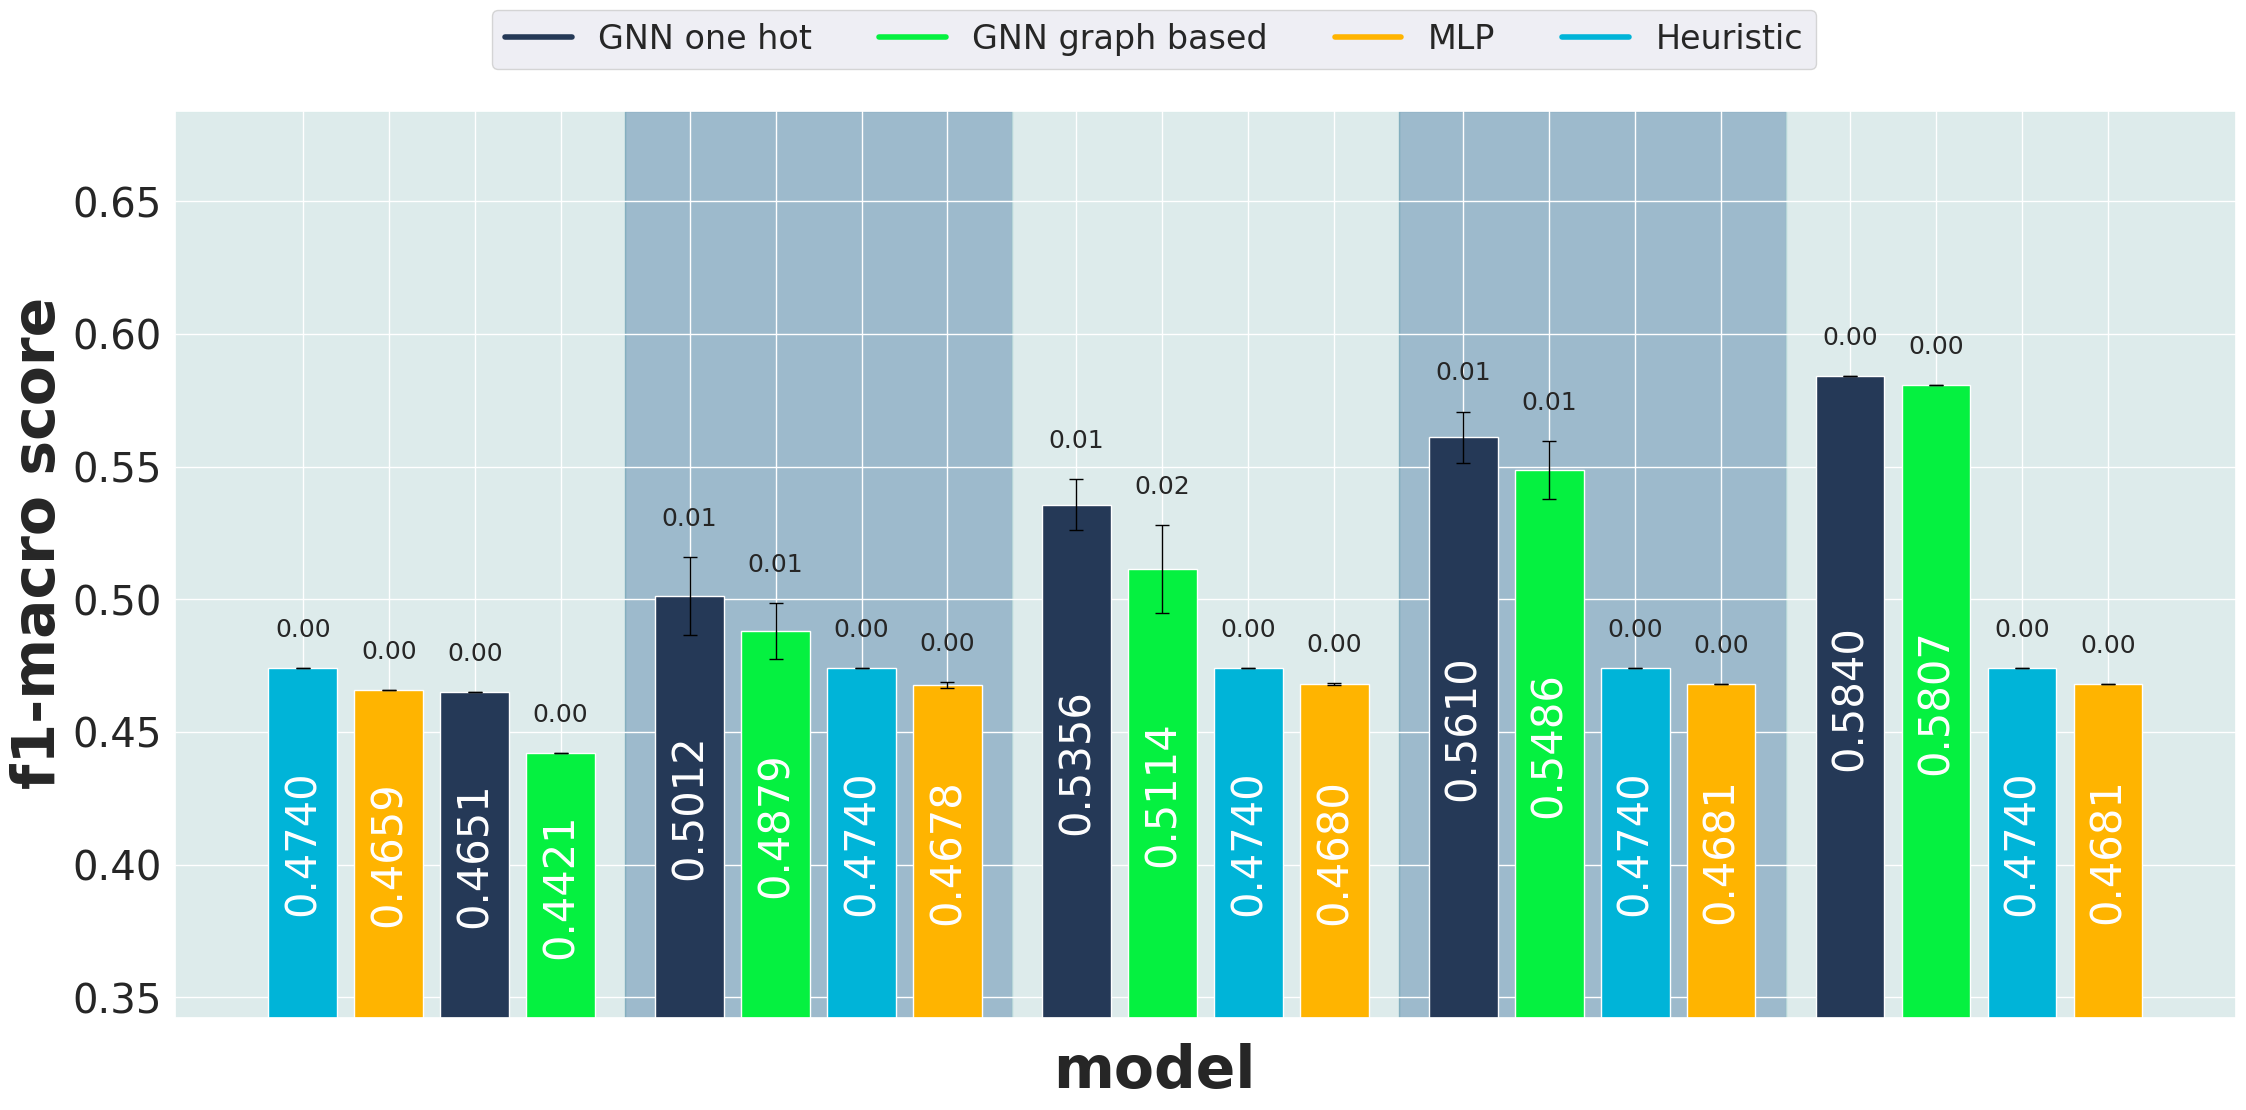

In [40]:
visualize_classifier_data_all_masks_mod(['/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_0',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_25',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_50',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_75',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_100'], sort_bars=True, annotate=True, mask_percent='all', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True,
                                     dataset_plot_only='CR')

### No masks, base scores

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, 
                              dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   
    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC', 'CR':'CR'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    all_dataset_dirs_mask = [True if d in dataset_names.keys() else False for d in all_dataset_dirs]
    all_dataset_dirs = (np.array(all_dataset_dirs)[all_dataset_dirs_mask]).tolist()
    print("Datasets:", all_dataset_dirs)
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    # --------------------------
    # First plot: Dataset stats
    # --------------------------
    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                results.setdefault(dataset_dir, []).append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
        stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
        if annotate:
            stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=14)

    plt.xlabel('dataset', fontsize=20)
    plt.ylabel('number of components', fontsize=20)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    # ---------------------------------------------------
    # Combined model performance: 5 subfigures arranged
    # with 2x2 grid for the first 4 and the 5th centered.
    # ---------------------------------------------------
    # Create a gridspec: first 2 rows (2 columns each) and a third row spanning both columns.
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:])
    axes_list = [ax1, ax2, ax3, ax4, ax5]

    # Lists to accumulate original x-tick (classifier) labels across subfigures
    global_classifier_labels = []  # will hold all classifier names (may contain duplicates)
    subfig_xtick_info = []         # list of tuples: (axis, list of classifier names for that subplot)
    
    all_handles, all_labels = [], []
    # Loop over each dataset directory and use one axis per dataset
    for ax, dataset_dir in zip(axes_list, all_dataset_dirs):
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results_dict = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''
                key = (curr_res['model_name'], ft)
                if key not in results_dict:
                    results_dict[key] = []
                if class_plot_only is None:
                    results_dict[key].append(curr_res['f1_macro'])
                else:
                    results_dict[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results_dict.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, stats in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            means.append(stats[0])
            std_devs.append(stats[1])
            all_fts.append(ft)
            all_metrics.append(stats[2])
        
        df_classifier = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df_classifier = df_classifier.sort_values('Mean', ascending=False)
        df_classifier = df_classifier.reset_index(drop=True)

        cols, hue_names = [], []
        color_model_scheme = {'GNN one hot':'#253957', 'GNN graph based':'#05F140', 
                              'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}
        for index, row in df_classifier.iterrows():
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristic'])
                hue_names.append('Heuristic')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in np.unique(hue_names):
            current_df = df_classifier.loc[np.array(hue_names) == u_n]
            best_model = current_df.loc[[current_df['Mean'].idxmax()]]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)
        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            # (Repeated sort/reset if needed removed for brevity)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], 
                                                     one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)
            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 
                                    'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                    'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        # Create the bar plot on the current axis
        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, 
                               y=one_best_model_per_class_df.Mean, 
                               data=one_best_model_per_class_df, 
                               palette=color_model_scheme, 
                               hue=one_best_model_per_class_hue_names, 
                               ax=ax, legend=None)
        
        # (Apply error bars, hatching, bar labels, etc.)
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # stripe bars
        # for i, bar in enumerate(sorted_bars):
        #     if i < len(all_pvalues) and all_pvalues[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)


        for container in bar_plot.containers:
            bar_plot.bar_label(container, label_type='center', rotation=90, color='white', fontsize=24)
        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=18)

        ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # (Optional: set color for specific x tick labels if desired)
        for tick in ax.get_xticklabels():
            if tick.get_text() not in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 
                                        'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                tick.set_color('black')
                # tick.set_weight('bold')

        ax.set_yticks([i * 0.1 for i in range(11)])
        ax.set_yticklabels(np.round([i * 0.1 for i in range(11)], 2), fontsize=18)
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean']) - 0.15, np.max(one_best_model_per_class_df['Mean']) + 0.1)

        ax.tick_params(axis='x', which='both', labelbottom=False) ################################# turn off xticklabels ###########################

        # Store the original classifier names for this subplot and accumulate globally
        orig_labels = one_best_model_per_class_df['Classifier'].tolist()
        global_classifier_labels.extend(orig_labels)
        subfig_xtick_info.append((ax, orig_labels))
        
        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    # After processing all subfigures, compute unique classifier names and build an encoding mapping.
    # We preserve order of first occurrence.
    unique_classifiers = list(dict.fromkeys(global_classifier_labels))
    mapping = { classifier: f"#{i}" for i, classifier in enumerate(unique_classifiers) }
    # Also build a reverse mapping: encoded label -> real classifier
    mapping_encoded_to_real = { f"#{i}": classifier for i, classifier in enumerate(unique_classifiers) }
    print("Mapping of new labels to real classifier names:")
    print(mapping_encoded_to_real)
    
    # Now update each subplot's x-tick labels with the encoded labels.
    for ax, orig_labels in subfig_xtick_info:
        new_labels = [mapping[label] for label in orig_labels]
        ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
    
    # Remove duplicate handles and labels for legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fontsize=24)
    fig.text(0.5, -0.02, 'model', ha='center', fontsize=29)
    fig.text(-0.02, 0.5, 'f1-macro score', va='center', rotation='vertical', fontsize=29)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


In [61]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data_mod(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, 
                              dataset_not_to_plot=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   
    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC', 'CR':'CR'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    all_dataset_dirs_mask = [True if d in dataset_names.keys() else False for d in all_dataset_dirs]
    all_dataset_dirs = (np.array(all_dataset_dirs)[all_dataset_dirs_mask]).tolist()
    print("Datasets:", all_dataset_dirs)
    if dataset_not_to_plot is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != dataset_not_to_plot]).tolist()

    # --------------------------
    # First plot: Dataset stats
    # --------------------------
    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                results.setdefault(dataset_dir, []).append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
        stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
        if annotate:
            stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=14)

    plt.xlabel('dataset', fontsize=20)
    plt.ylabel('number of components', fontsize=20)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    # ---------------------------------------------------
    # Combined model performance: 5 subfigures arranged
    # with 2x2 grid for the first 4 and the 5th centered.
    # ---------------------------------------------------
    # Create a gridspec: first 2 rows (2 columns each) and a third row spanning both columns.
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:])
    ax3 = fig.add_subplot(gs[1, :3])
    ax4 = fig.add_subplot(gs[1, 3:])
    axes_list = [ax1, ax2, ax3, ax4]

    # Lists to accumulate original x-tick (classifier) labels across subfigures
    global_classifier_labels = []  # will hold all classifier names (may contain duplicates)
    subfig_xtick_info = []         # list of tuples: (axis, list of classifier names for that subplot)
    
    all_handles, all_labels = [], []
    # Loop over each dataset directory and use one axis per dataset
    for ax, dataset_dir in zip(axes_list, all_dataset_dirs):
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results_dict = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''
                key = (curr_res['model_name'], ft)
                if key not in results_dict:
                    results_dict[key] = []
                if class_plot_only is None:
                    results_dict[key].append(curr_res['f1_macro'])
                else:
                    results_dict[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results_dict.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, stats in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            means.append(stats[0])
            std_devs.append(stats[1])
            all_fts.append(ft)
            all_metrics.append(stats[2])
        
        df_classifier = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df_classifier = df_classifier.sort_values('Mean', ascending=False)
        df_classifier = df_classifier.reset_index(drop=True)

        cols, hue_names = [], []
        color_model_scheme = {'GNN one hot':'#253957', 'GNN graph based':'#05F140', 
                              'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}
        for index, row in df_classifier.iterrows():
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristic'])
                hue_names.append('Heuristic')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in np.unique(hue_names):
            current_df = df_classifier.loc[np.array(hue_names) == u_n]
            best_model = current_df.loc[[current_df['Mean'].idxmax()]]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)
        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            # (Repeated sort/reset if needed removed for brevity)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], 
                                                     one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)
            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 
                                    'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                    'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        # Create the bar plot on the current axis
        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, 
                               y=one_best_model_per_class_df.Mean, 
                               data=one_best_model_per_class_df, 
                               palette=color_model_scheme, 
                               hue=one_best_model_per_class_hue_names, 
                               ax=ax, legend=None)
        
        # (Apply error bars, hatching, bar labels, etc.)
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # stripe bars
        # for i, bar in enumerate(sorted_bars):
        #     if i < len(all_pvalues) and all_pvalues[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)


        for container in bar_plot.containers:
            bar_plot.bar_label(container, label_type='center', rotation=90, color='white', fontsize=24)
        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=18)

        ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # (Optional: set color for specific x tick labels if desired)
        for tick in ax.get_xticklabels():
            if tick.get_text() not in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 
                                        'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                tick.set_color('black')
                # tick.set_weight('bold')

        ax.set_yticks([i * 0.1 for i in range(11)])
        ax.set_yticklabels(np.round([i * 0.1 for i in range(11)], 2), fontsize=18)
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean']) - 0.15, np.max(one_best_model_per_class_df['Mean']) + 0.1)

        ax.tick_params(axis='x', which='both', labelbottom=False) ################################# turn off xticklabels ###########################

        # Store the original classifier names for this subplot and accumulate globally
        orig_labels = one_best_model_per_class_df['Classifier'].tolist()
        global_classifier_labels.extend(orig_labels)
        subfig_xtick_info.append((ax, orig_labels))
        
        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    # After processing all subfigures, compute unique classifier names and build an encoding mapping.
    # We preserve order of first occurrence.
    unique_classifiers = list(dict.fromkeys(global_classifier_labels))
    mapping = { classifier: f"#{i}" for i, classifier in enumerate(unique_classifiers) }
    # Also build a reverse mapping: encoded label -> real classifier
    mapping_encoded_to_real = { f"#{i}": classifier for i, classifier in enumerate(unique_classifiers) }
    print("Mapping of new labels to real classifier names:")
    print(mapping_encoded_to_real)
    
    # Now update each subplot's x-tick labels with the encoded labels.
    for ax, orig_labels in subfig_xtick_info:
        new_labels = [mapping[label] for label in orig_labels]
        ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
    
    # Remove duplicate handles and labels for legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fontsize=24)
    fig.text(0.5, -0.02, 'model', ha='center', fontsize=29)
    fig.text(-0.02, 0.5, 'f1-macro score', va='center', rotation='vertical', fontsize=29)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}_not_cr_only.pdf', bbox_inches="tight")
    plt.show()


In [62]:
visualize_classifier_data_mod('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True,
                              dataset_not_to_plot='CR')

Datasets: ['Scandinavia', 'Western-Europe', 'NC_graph_rel_eng', 'Volga', 'CR']


Mapping of new labels to real classifier names:
{'#0': 'GL_TAGConv_3l_512h_w_k3_gnorm_gelu', '#1': 'GL_TAGConv_9l_512h_w_k3', '#2': 'GL_MLP_3l_512h', '#3': 'MaxIbdSumPerClassSize', '#4': 'LabelPropagation', '#5': 'GL_TAGConv_3l_512h_w_k3', '#6': 'MaxIbdSum', '#7': 'GL_GATConv_3l_512h', '#8': 'GL_MLP_9l_512h', '#9': 'GL_TAGConv_3l_512h_w_k3_gnorm', '#10': 'GL_SAGEConv_9l_512h', '#11': 'GL_TAGConv_3l_512h_w_k3_gnorm_leaky_relu', '#12': 'GL_MLP_3l_128h', '#13': 'LongestIbd'}


/tmp/ipykernel_2456437/1257834973.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_2456437/1257834973.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_2456437/1257834973.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_2456437/1257834973.py:275: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)


# Distribution figs

In [37]:
import sys
import os
import torch
import pickle
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
from utils.genlink import DataProcessor, NullSimulator, Trainer

In [46]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/Western-Europe.csv')

In [47]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='WE', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/WE_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

In [44]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/CR.csv')

In [45]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='CR', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/CR_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

In [48]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/NC_graph_rel_eng.csv')

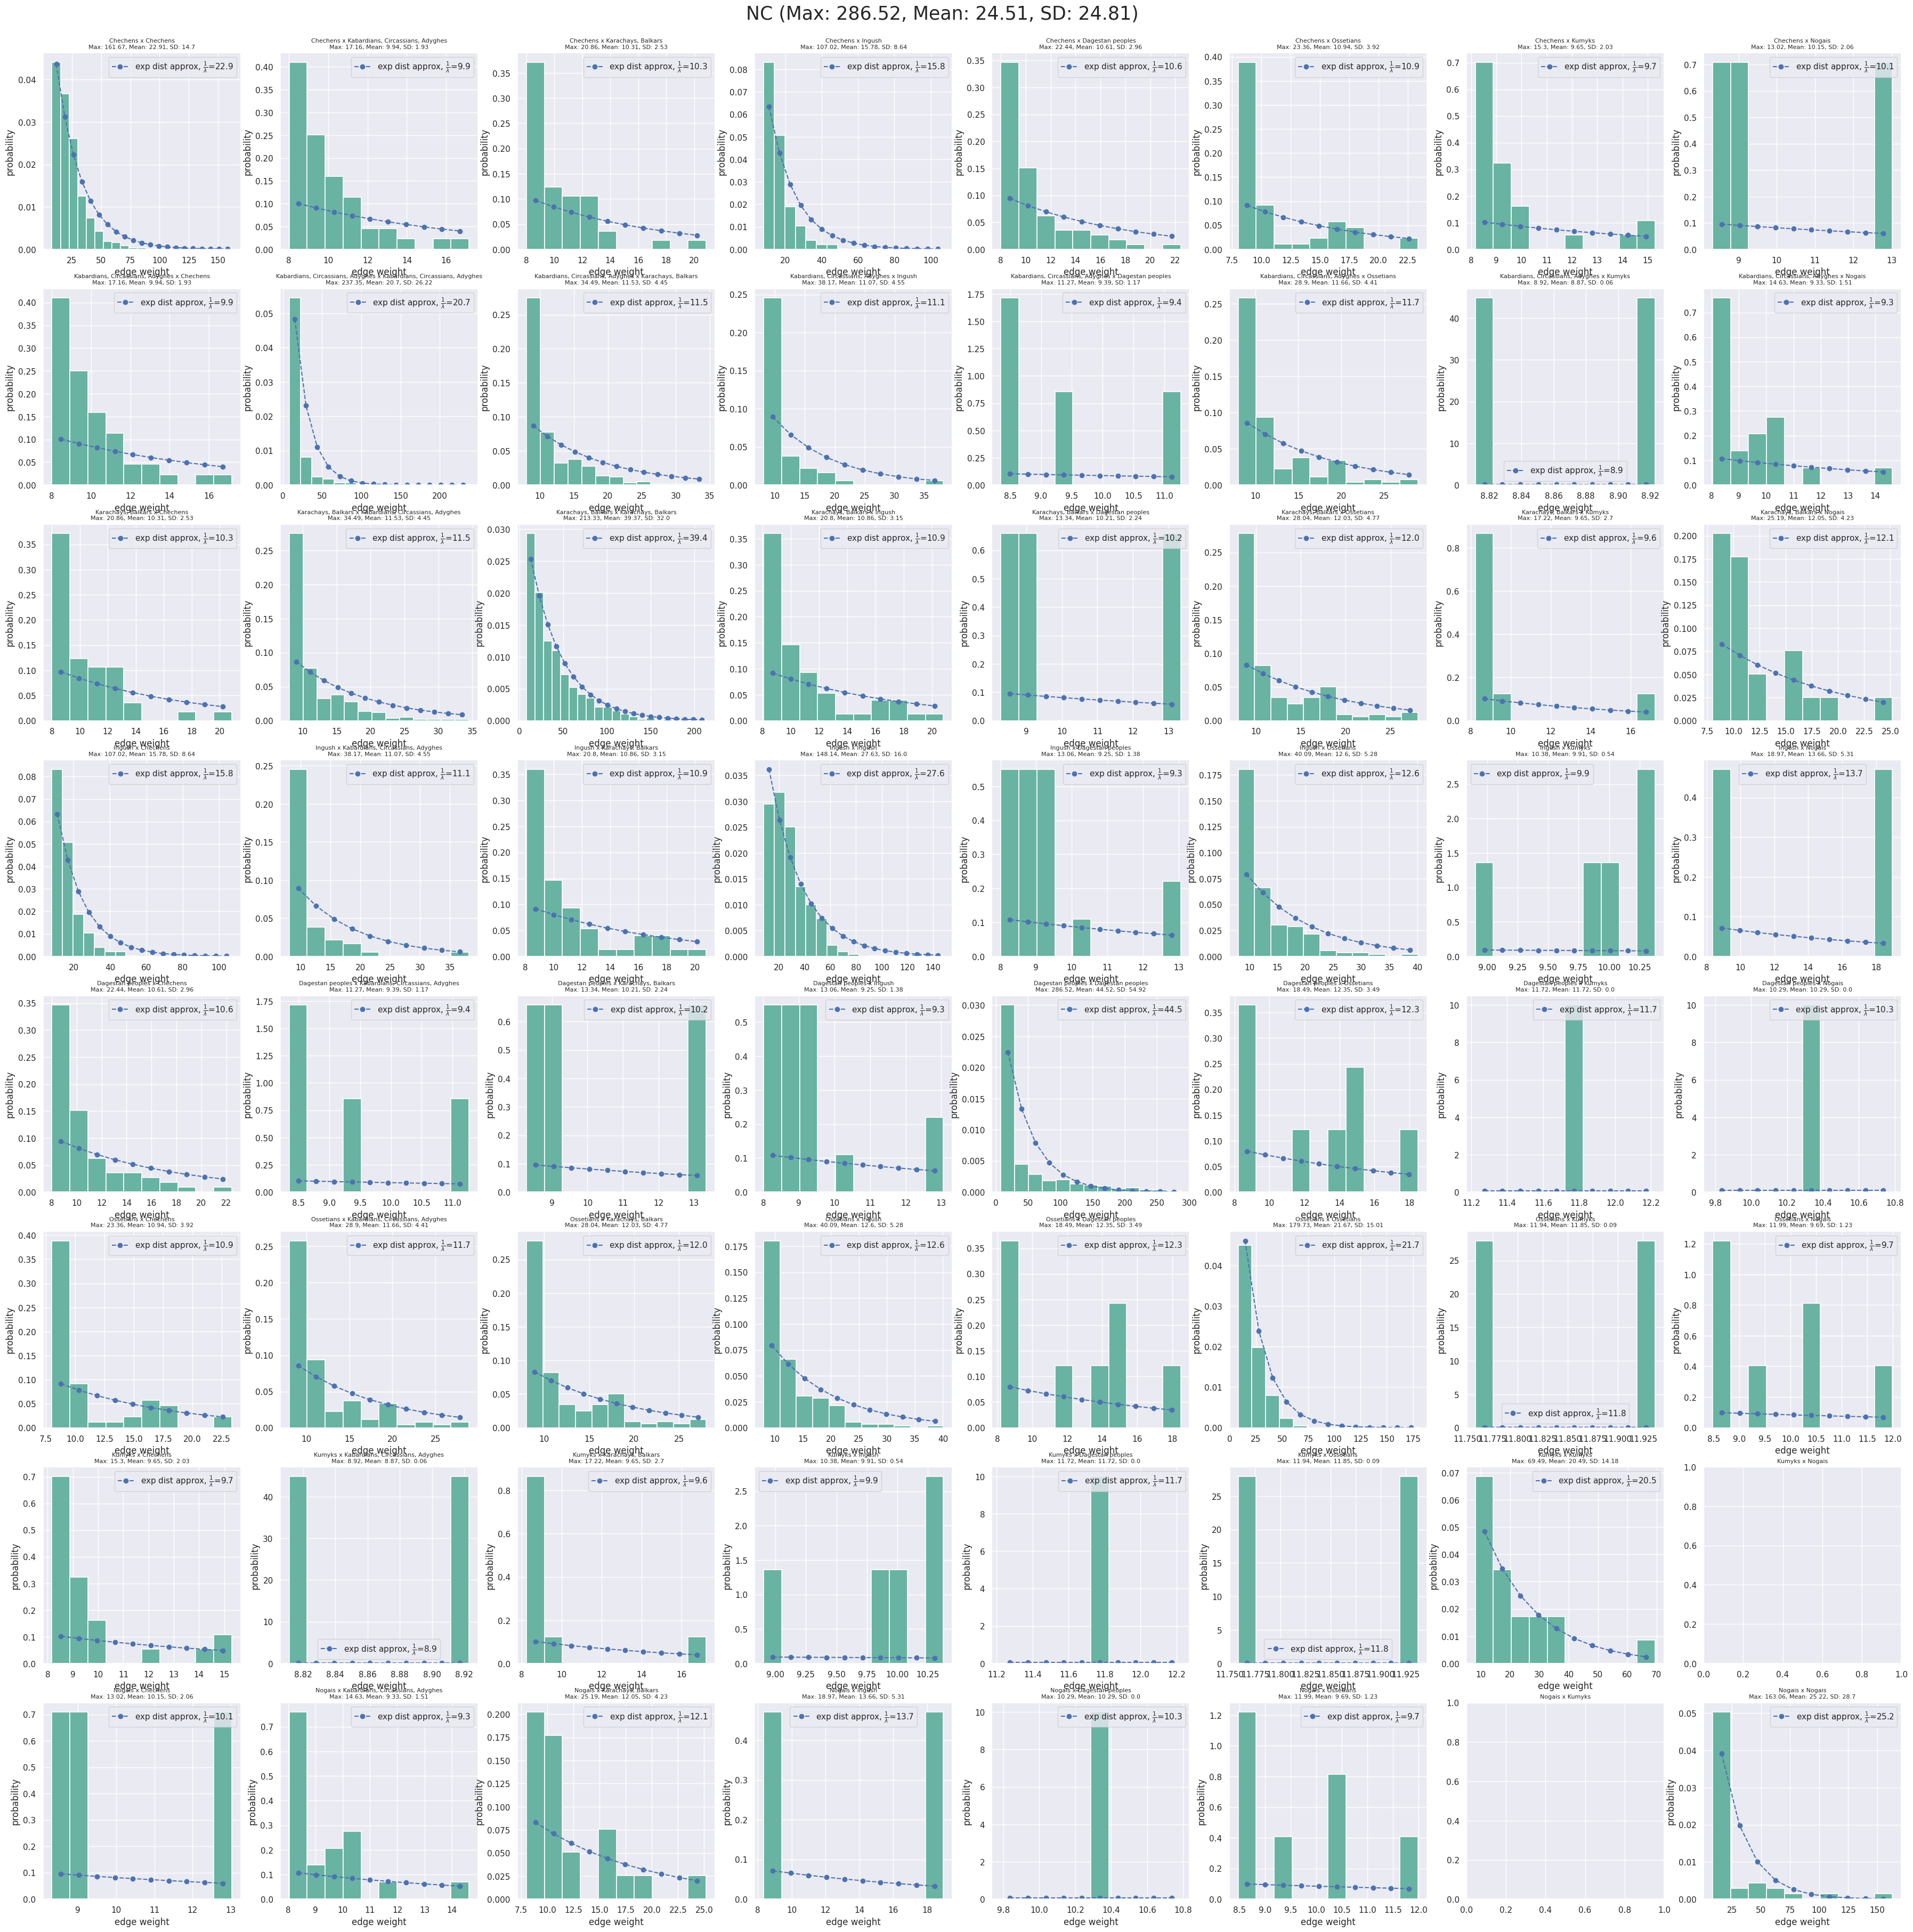

In [49]:
dp.plot_edge_weight_distribution(fig_size=(45, 45), dataset_name='NC', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/NC_dataset_weight_dist.pdf',
                                 title_pos=0.9, title_font_size=25)

In [50]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/Scandinavia.csv')

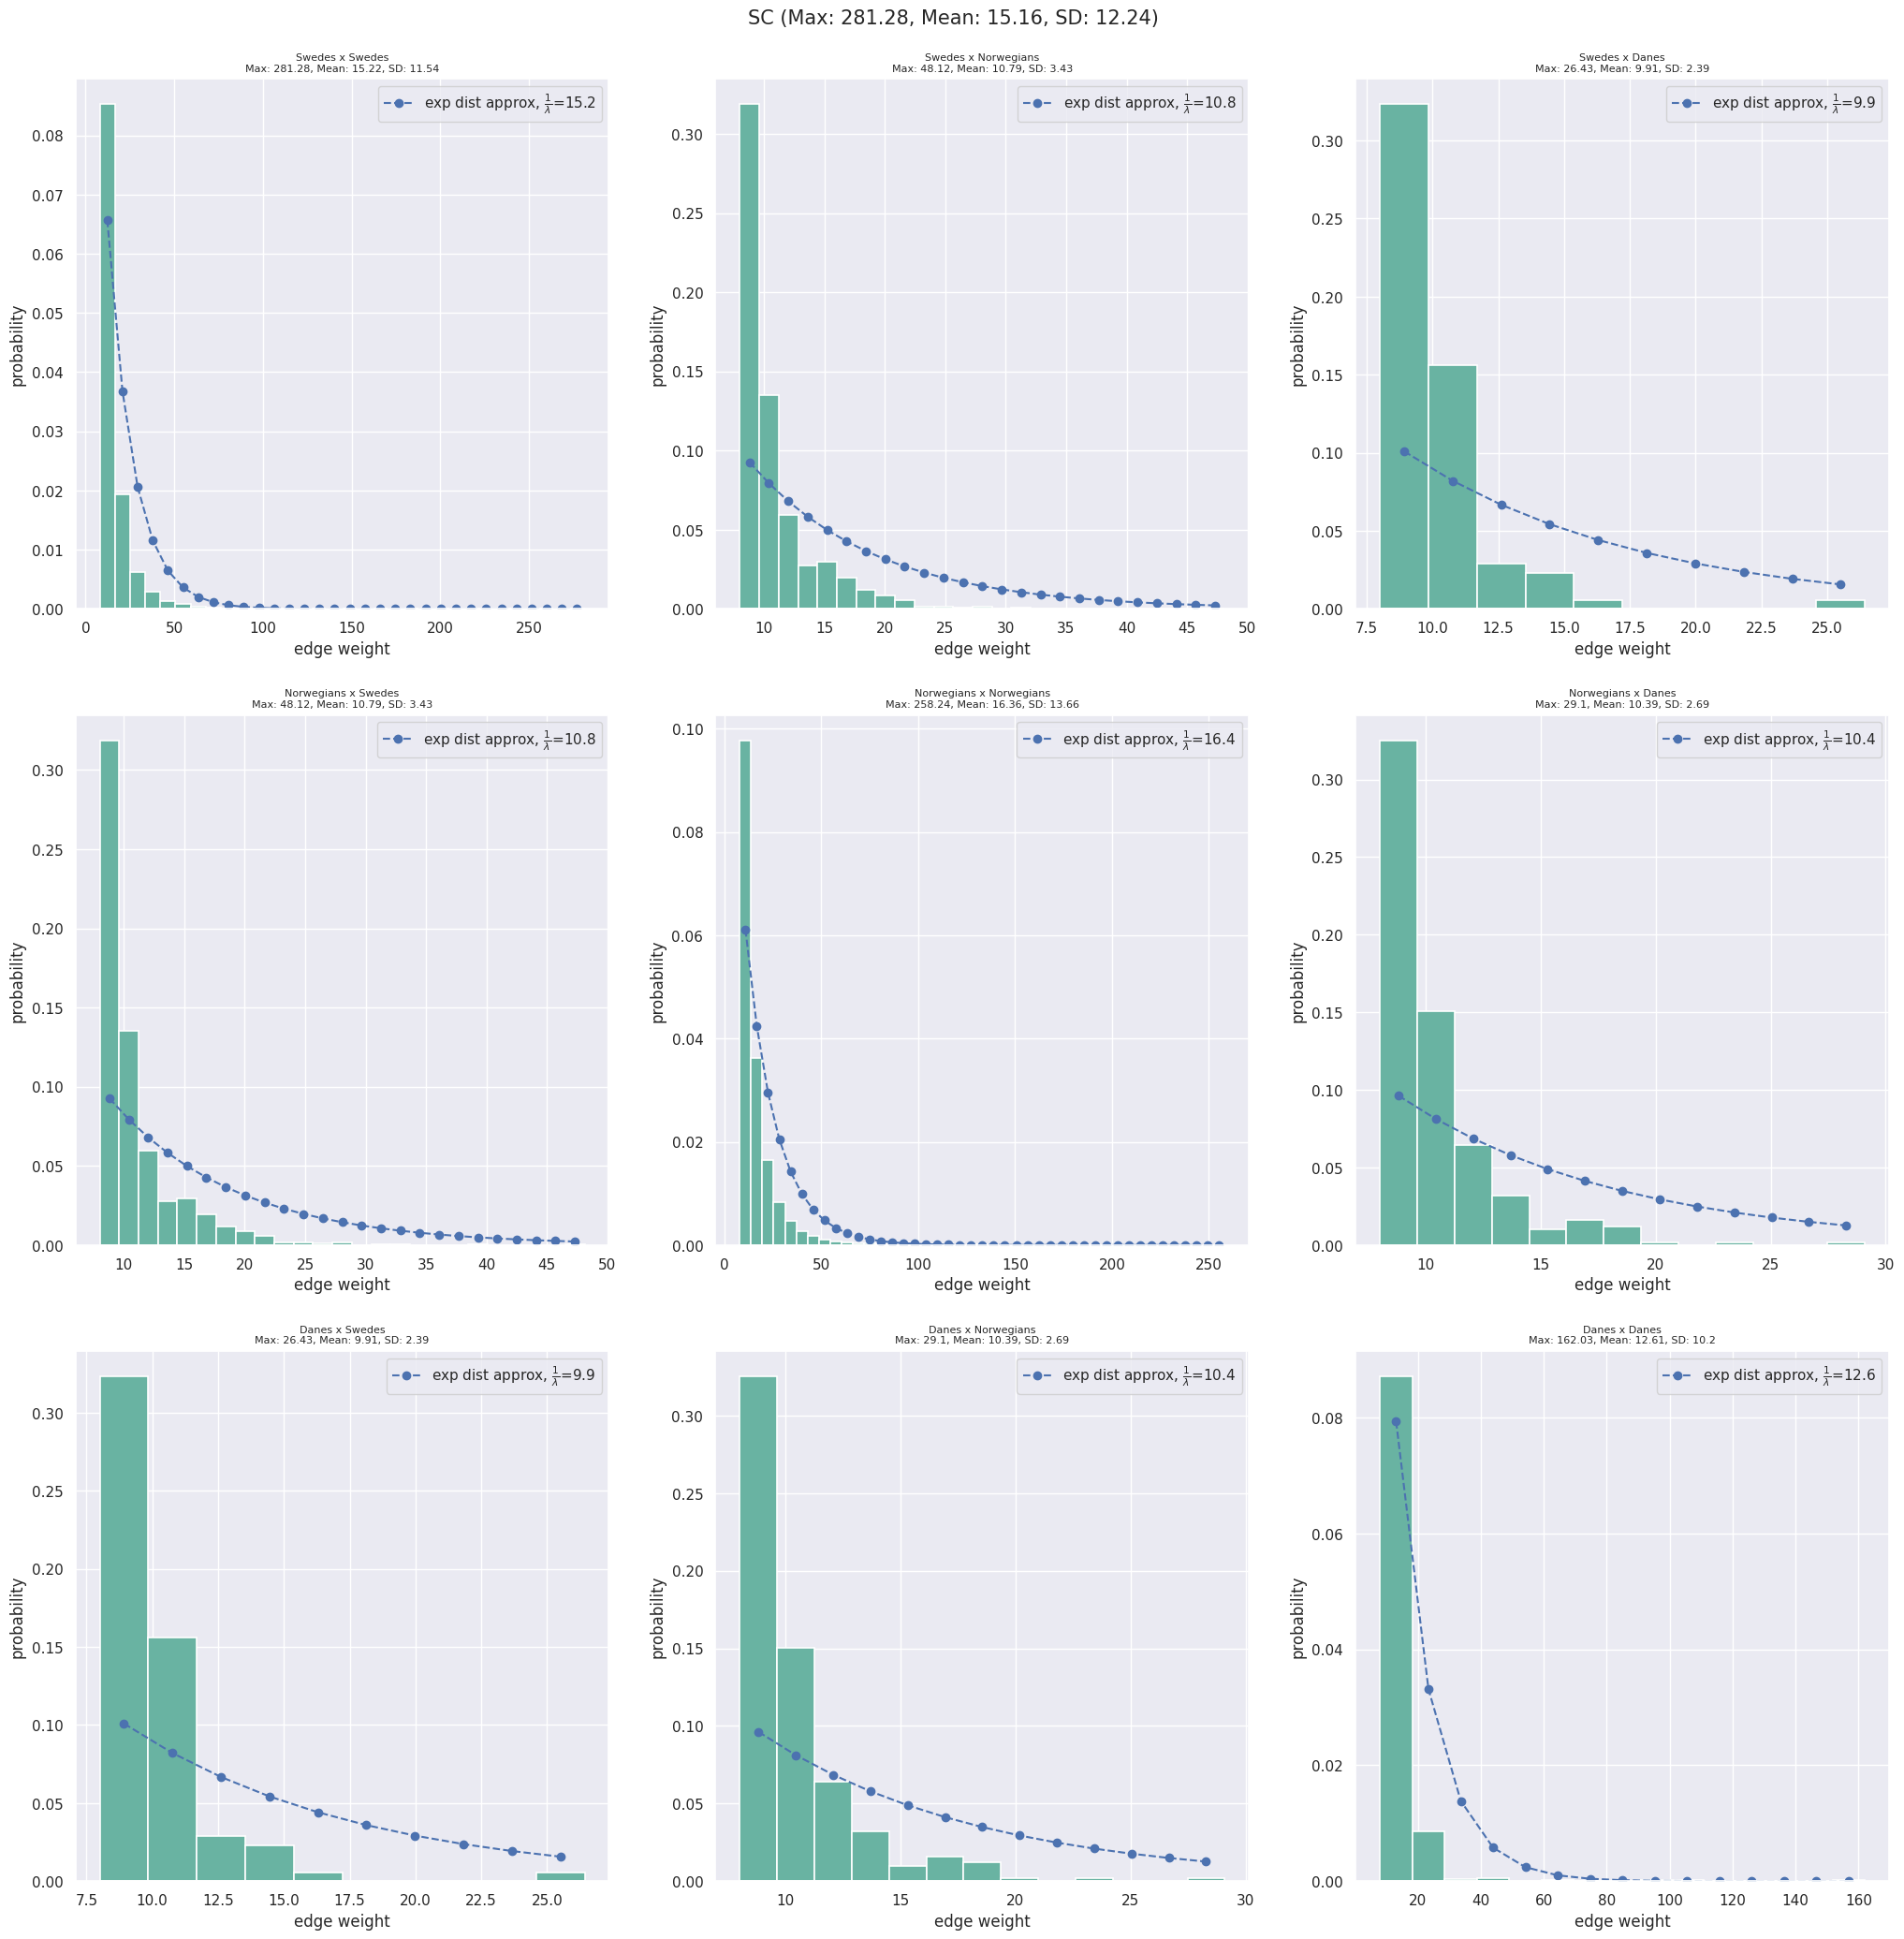

In [51]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='SC', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/SC_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

In [52]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/Volga.csv')

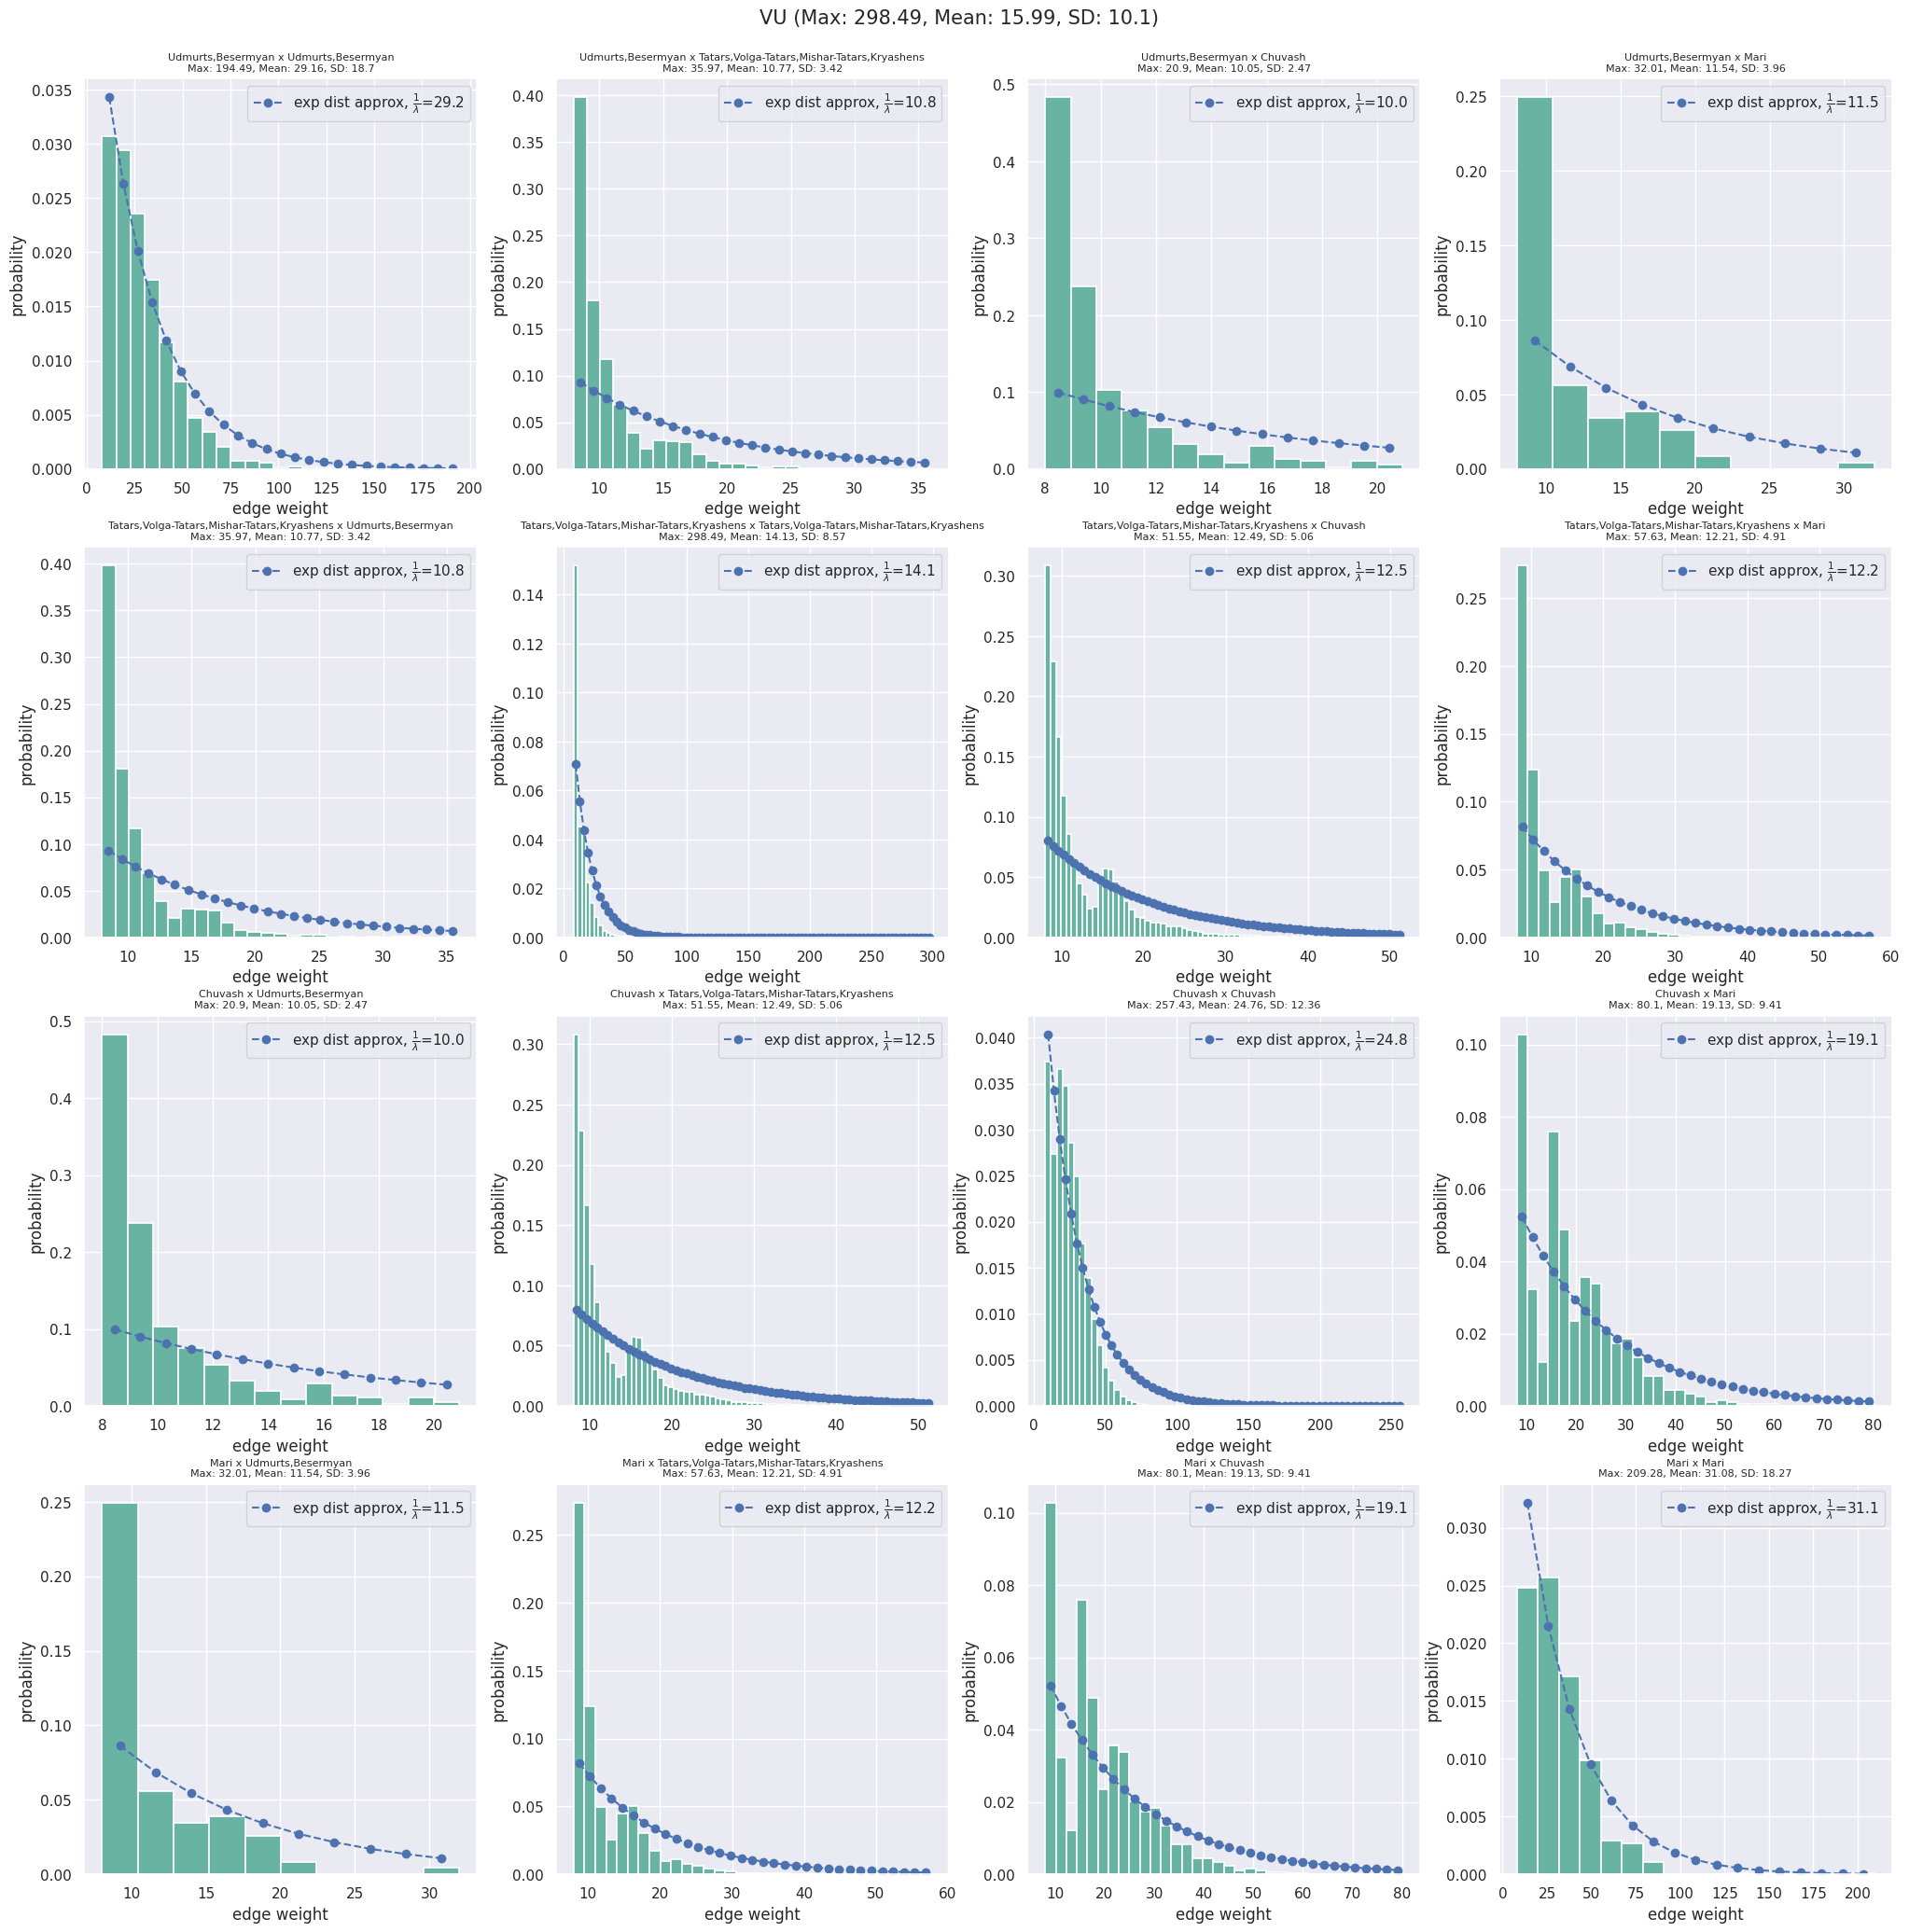

In [53]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='VU', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/VU_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

# Modularity figs

In [1]:
import sys
import os
import torch
import pickle
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
from utils.genlink import DataProcessor, NullSimulator, Trainer

In [4]:
dp = DataProcessor('/disk/10tb/home/shmelev/real_data_simulation_diagonal_changer/Volga_diagonal_probs_multiplied_by_0_100.csv')

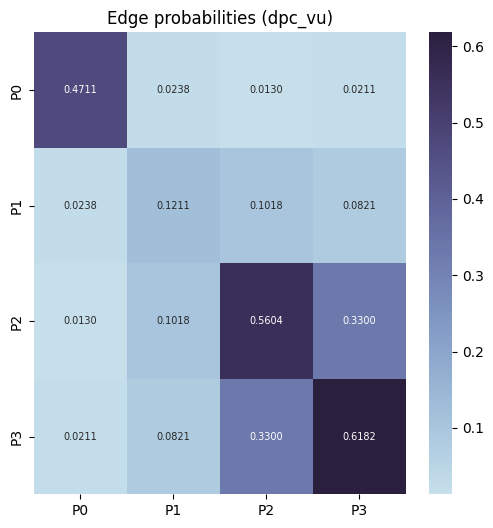

In [5]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='dpc_vu', save_path=None)

In [2]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/CR.csv')

In [4]:
dp.plot_modularity_matrix(dataset_name='CR', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/CR_modularity.pdf')

In [5]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='CR', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/CR_edge_prob.pdf')

In [6]:
dp = DataProcessor('/disk/10tb/home/shmelev/genlink_real_data/Volga.csv')

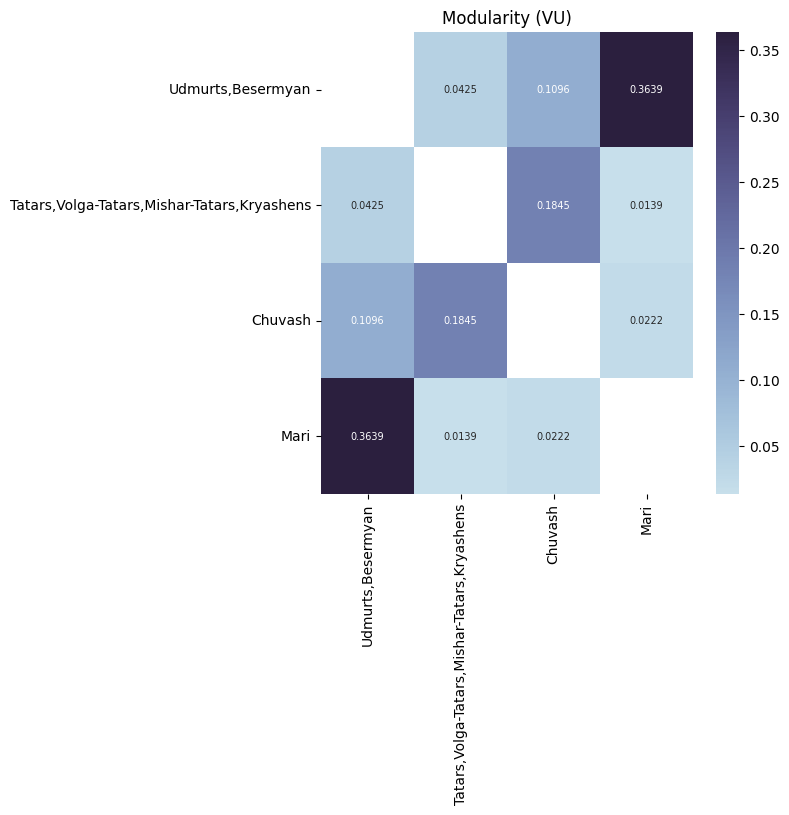

In [8]:
dp.plot_modularity_matrix(dataset_name='VU', save_path='/disk/10tb/home/shmelev/GENLINK/pictures/VU_modularity.pdf')

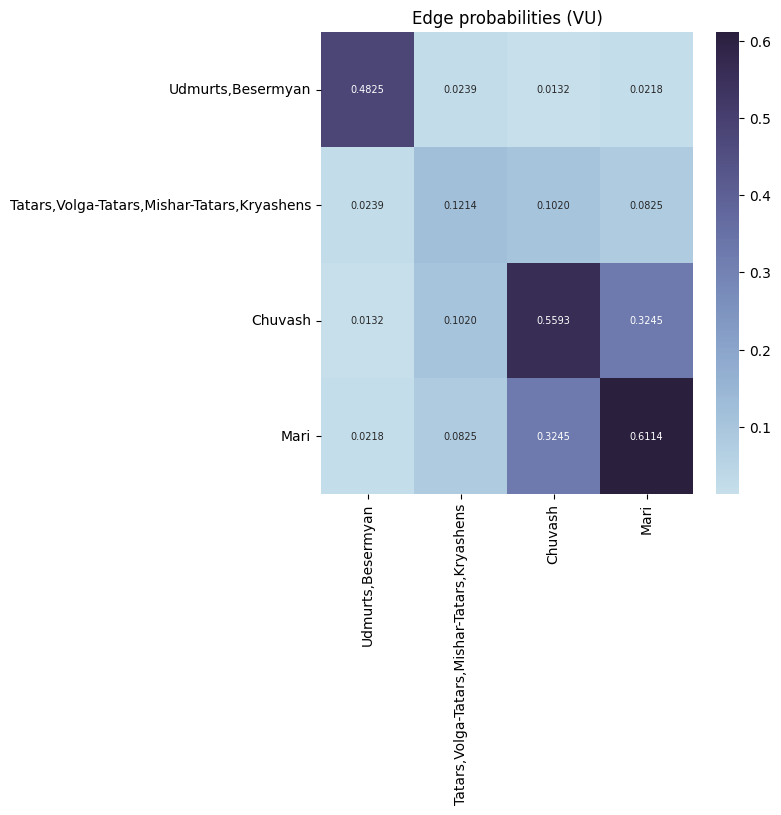

In [13]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='VU', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/VU_edge_prob.pdf')

In [14]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/NC_graph_rel_eng.csv')

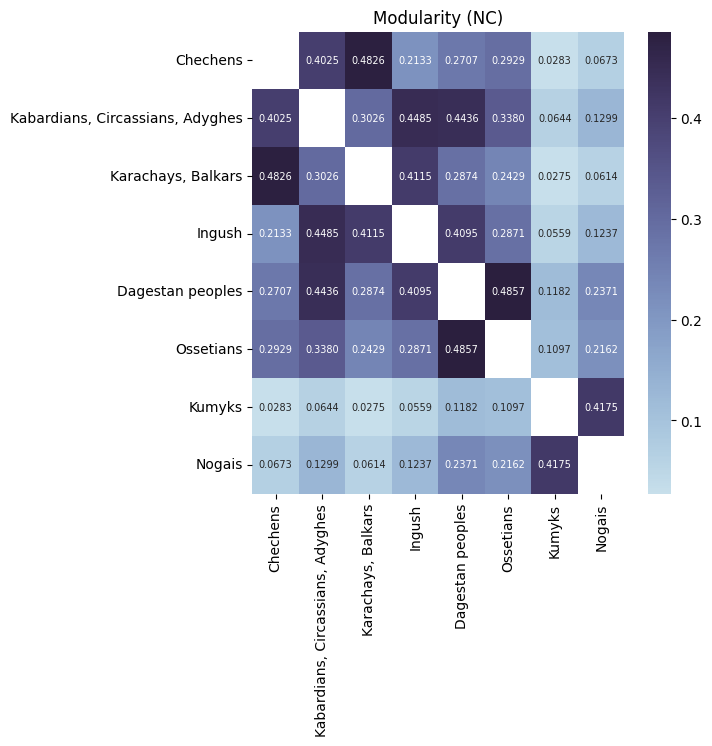

In [15]:
dp.plot_modularity_matrix(dataset_name='NC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/NC_modularity.pdf')

/mnt/10tb/home/shmelev/GENLINK/utils/genlink.py:1341: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean()# - self.offset
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/10tb/home/shmelev/GENLINK/utils/genlink.py:1341: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean()# - self.offset
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


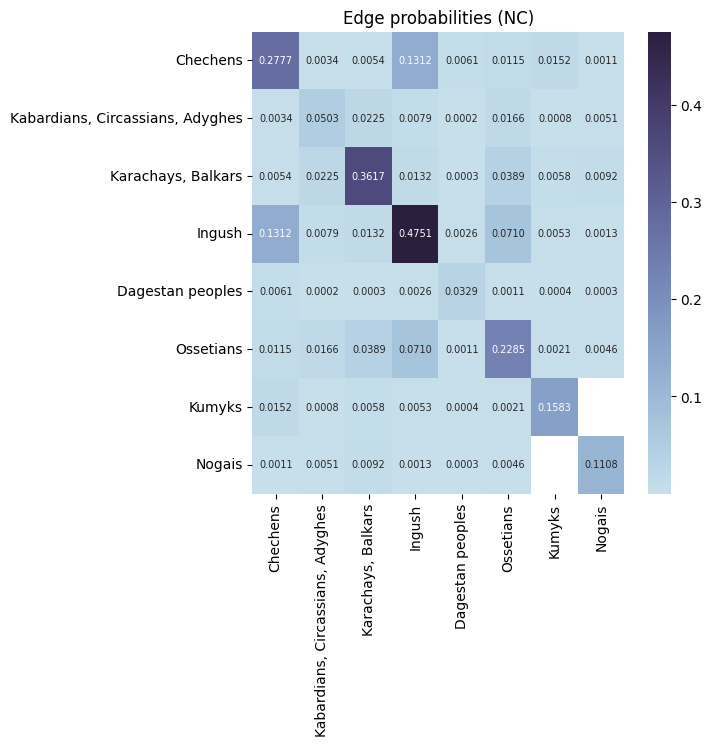

In [16]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='NC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/NC_edge_prob.pdf')

In [17]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Scandinavia.csv')

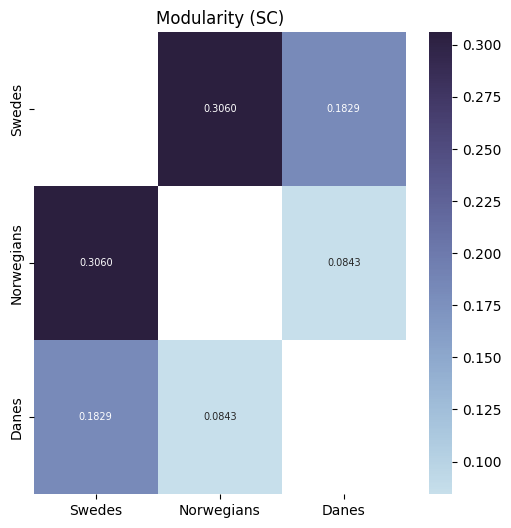

In [18]:
dp.plot_modularity_matrix(dataset_name='SC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/SC_modularity.pdf')

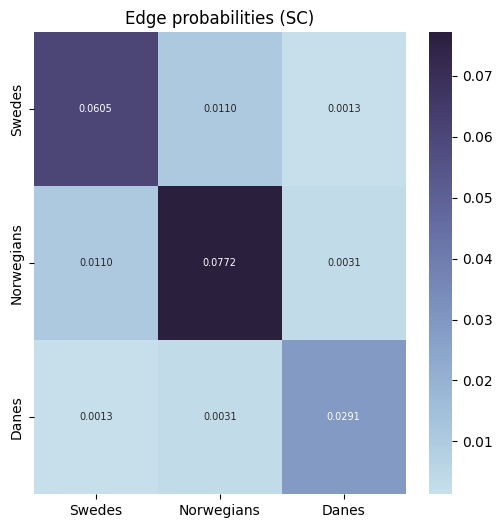

In [19]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='SC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/SC_edge_prob.pdf')

In [20]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Western-Europe.csv')

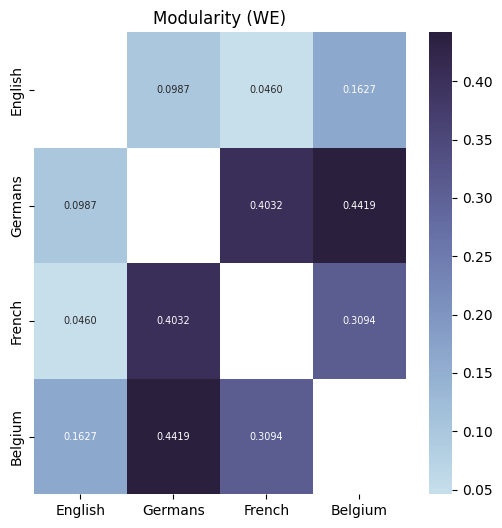

In [21]:
dp.plot_modularity_matrix(dataset_name='WE', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/WE_modularity.pdf')

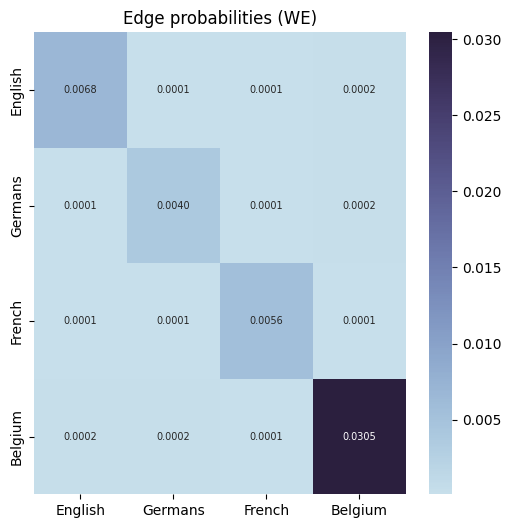

In [22]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='WE', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/WE_edge_prob.pdf')